<a href="https://colab.research.google.com/github/hhoppe/advent_of_code_2018/blob/main/advent_of_code_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name="top"></a>
# Advent of code 2018

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code_2018/blob/main/advent_of_code_2018.ipynb)

IPython/Jupyter [notebook](https://github.com/hhoppe/advent_of_code_2018/blob/main/advent_of_code_2018.ipynb) by [Hugues Hoppe](http://hhoppe.com/) with solutions to the [2018 Advent of Code puzzles](https://adventofcode.com/2018).

Mostly completed in November 2021.

See my [**2020** Advent-of-Code notebook](https://github.com/hhoppe/advent_of_code_2020) for notes on how the code is structured.

<a name="preamble"></a>
## Preamble

In [1]:
!pip install -q advent-of-code-hhoppe hhoppe-utils mediapy

In [2]:
import collections
import dataclasses
import functools
import heapq
import itertools
import math
import re
import textwrap
from typing import Any, Callable, Dict, List
from typing import Optional, Set, Tuple, Union

import advent_of_code_hhoppe
import hhoppe_utils as hh
import mediapy as media
import numpy as np
import scipy.optimize

In [3]:
YEAR = 2018

In [4]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
ZIP_URL = f'https://github.com/hhoppe/advent_of_code_{YEAR}/raw/main/data/{PROFILE}.zip'
!if [[ ! -d {PROFILE} ]]; then wget -q {ZIP_URL} && unzip -q {PROFILE}; fi
INPUT_URL = f'{PROFILE}/{{year}}_{{day:02d}}_input.txt'
ANSWER_URL = f'{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [5]:
# (2) If URLs not found, we may try adventofcode.com using a session cookie:
if 0:
  # See https://github.com/wimglenn/advent-of-code-data.
  !rm -f ~/.config/aocd/token*
  # Fill-in the session cookie in the following:
  !if [ '{PROFILE}' == 'google.Hugues_Hoppe.965276' ]; then mkdir -p ~/.config/aocd && echo 53616... >~/.config/aocd/token; fi
  !if [ '{PROFILE}' == 'github.hhoppe.1452460' ]; then mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token; fi
  !pip install -q advent-of-code-data
  import aocd

In [6]:
try:
  import numba
  using_numba = True
  numba_njit = numba.njit
except ModuleNotFoundError:
  print('numba unavailable')
  using_numba = False
  def noop_decorator(*args: Any, **kwargs: Any) -> Any:
    """Function decorator that ignores any arguments and does nothing."""
    return (args[0] if len(args) == 1 and callable(args[0]) and not kwargs
            else noop_decorator)
  numba_njit = noop_decorator

In [7]:
advent = advent_of_code_hhoppe.Advent(
    year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

### Helper functions

In [8]:
check_eq = hh.check_eq

### `Machine` used in several puzzles

In [9]:
@dataclasses.dataclass
class Machine:
  num_registers: int = 6
  registers = None
  ip_register: Optional[int] = None
  instructions = None
  ip: int = 0

  @dataclasses.dataclass
  class Instruction:
    operation: str
    operands: List[int]

  def __post_init__(self):
    self.registers = [0] * self.num_registers

    def assign(registers, operands, value):
      output = operands[2]
      assert 0 <= output < len(registers)
      registers[output] = int(value)

    self.operations = {
        'addr': lambda r, o: assign(r, o, r[o[0]] + r[o[1]]),
        'addi': lambda r, o: assign(r, o, r[o[0]] + o[1]),
        'mulr': lambda r, o: assign(r, o, r[o[0]] * r[o[1]]),
        'muli': lambda r, o: assign(r, o, r[o[0]] * o[1]),
        'banr': lambda r, o: assign(r, o, r[o[0]] & r[o[1]]),
        'bani': lambda r, o: assign(r, o, r[o[0]] & o[1]),
        'borr': lambda r, o: assign(r, o, r[o[0]] | r[o[1]]),
        'bori': lambda r, o: assign(r, o, r[o[0]] | o[1]),
        'setr': lambda r, o: assign(r, o, r[o[0]]),
        'seti': lambda r, o: assign(r, o, o[0]),
        'gtir': lambda r, o: assign(r, o, o[0] > r[o[1]]),
        'gtri': lambda r, o: assign(r, o, r[o[0]] > o[1]),
        'gtrr': lambda r, o: assign(r, o, r[o[0]] > r[o[1]]),
        'eqir': lambda r, o: assign(r, o, o[0] == r[o[1]]),
        'eqri': lambda r, o: assign(r, o, r[o[0]] == o[1]),
        'eqrr': lambda r, o: assign(r, o, r[o[0]] == r[o[1]]),
    }

  def read_instructions(self, s):
    lines = s.strip('\n').split('\n')
    if lines[0].startswith('#ip'):
      self.ip_register = int(re.fullmatch('#ip (\d+)', lines[0]).group(1))
      lines = lines[1:]
    self.instructions = []
    for line in lines:
      operation, *operands = line.split()
      operands = tuple(map(int, operands))
      assert operation in self.operations and len(operands) == 3
      self.instructions.append(self.Instruction(operation, operands))

  def run_instruction(self, verbose=False):
    if self.ip_register is not None:
      self.registers[self.ip_register] = self.ip
    instruction = self.instructions[self.ip]
    self.operations[instruction.operation](self.registers, instruction.operands)
    if verbose:
      print(self.ip, instruction.operation, instruction.operands,
            self.registers)
    if self.ip_register is not None:
      self.ip = self.registers[self.ip_register] + 1
    else:
      self.ip += 1

<a name="day1"></a>
## Day 1: Repeat in running sum

- Part 1: Find sum of list of numbers.

- Part 2: Find value of running sum that first repeats.

In [10]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2018/day/1), `puzzle.input` has 986 lines:

-1
-7
-5
-16
-2
-11
-17
+14
 ...
-7
+10
-6
+125648


The stored answers are: `{1: '466', 2: '750'}`

In [11]:
def process1(s):
  entries = map(int, s.replace(', ', '\n').strip('\n').split('\n'))
  return sum(entries)

check_eq(process1('+1, +1, +1'), 3)
check_eq(process1('+1, +1, -2'), 0)
check_eq(process1('-1, -2, -3'), -6)
puzzle.verify(1, process1)

(Part 1: 0.000 s)


In [12]:
def process2(s):
  entries = map(int, s.replace(', ', '\n').strip('\n').split('\n'))
  total = 0
  found = set()
  for value in itertools.cycle(entries):
    found.add(total)
    total += value
    if total in found:
      return total
  assert False

check_eq(process2('+1, -1'), 0)
check_eq(process2('+3, +3, +4, -2, -4'), 10)
check_eq(process2('-6, +3, +8, +5, -6'), 5)
check_eq(process2('+7, +7, -2, -7, -4'), 14)
puzzle.verify(2, process2)

(Part 2: 0.050 s)


<a name="day2"></a>
## Day 2: Ids with repeated letters

- Part 1: Count the ids that have a letter repeated twice, and the ids that have a letter repeated thrice.  Return the product of the counts.

- Part 2: Find two ids that differ in just one letter, and return the id without the differing letter.

In [13]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2018/day/2), `puzzle.input` has 250 lines:

qysdgimlcaghpfozuwejmhrbvx
qysdtiklcagnpfhzuwbjmhrtvx
qysdtiflcsgnpfozuwejmhruvx
qkshtiklnagnpfozuwejmhrbvx
qysdtnklcagnpmozuwejmhrrvx
qysdttkecagnpfozuwijmhrbvx
qyedtiklcagnvfozuweymhrbvx
qyzdtikzcagnpfozuwejmhqbvx
 ...
qysdtiklcaknpfozuwejcwrbvx
qysytiklcagnpfozdfejmhrbvx
qysdtiklcagmpfozuwejmgrbox
qysdtielcagnpfpzuwejhhrbvx


The stored answers are: `{1: '4980', 2: 'qysdtrkloagnfozuwujmhrbvx'}`

In [14]:
def process1(s):
  sum_twice = sum_thrice = 0
  for id in s.split():
    counts = collections.Counter(id)
    sum_twice += 2 in counts.values()
    sum_thrice += 3 in counts.values()
  return sum_twice * sum_thrice

check_eq(process1('abcdef bababc abbcde abcccd aabcdd abcdee ababab'), 4 * 3)
puzzle.verify(1, process1)

(Part 1: 0.003 s)


In [15]:
def process2(s):
  candidates = set()
  for id in s.split():
    for pos in range(len(id)):
      id2 = id[:pos] + '*' + id[pos + 1:]
      if id2 in candidates:
        return id2.replace('*', '')
      candidates.add(id2)
  return None

check_eq(process2('abcde fghij klmno pqrst fguij axcye wvxyz'), 'fgij')
puzzle.verify(2, process2)

(Part 2: 0.006 s)


<a name="day3"></a>
## Day 3: Overlapping rectangles

- Part 1: Count the number of grid squares that are covered by at least two rectangles.

- Part 2: Find the rectangle that does not overlap with any other rectangle.

In [16]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2018/day/3), `puzzle.input` has 1265 lines:

#1 @ 871,327: 16x20
#2 @ 676,717: 27x26
#3 @ 245,818: 19x21
#4 @ 89,306: 22x11
#5 @ 451,712: 20x11
#6 @ 322,299: 24x29
#7 @ 161,304: 10x29
#8 @ 746,459: 19x25
 ...
#1262 @ 359,24: 15x22
#1263 @ 49,668: 26x22
#1264 @ 629,465: 10x9
#1265 @ 429,317: 24x28


The stored answers are: `{1: '101565', 2: '656'}`

In [17]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  pattern = r'#(\d+) @ (\d+),(\d+): (\d+)x(\d+)'
  grid = collections.defaultdict(int)
  for line in lines:
    claim, l, t, w, h = map(int, re.fullmatch(pattern, line).groups())
    for y in range(t, t + h):
      for x in range(l, l + w):
        grid[y, x] += 1

  if not part2:
    return sum(value >= 2 for value in grid.values())

  found = []
  for line in lines:
    claim, l, t, w, h = map(int, re.fullmatch(pattern, line).groups())
    if all(grid[y, x] == 1 for y in range(t, t + h) for x in range(l, l + w)):
      found.append(claim)
  return (lambda x: x)(*found)


check_eq(process1('#1 @ 1,3: 4x4\n#2 @ 3,1: 4x4\n#3 @ 5,5: 2x2'), 4)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2('#1 @ 1,3: 4x4\n#2 @ 3,1: 4x4\n#3 @ 5,5: 2x2'), 3)
puzzle.verify(2, process2)

(Part 1: 0.336 s)
(Part 2: 0.331 s)


<a name="day4"></a>
## Day 4: Guard sleep patterns

- Part 1: Find the guard that has the most minutes asleep.  What minute does that guard spend asleep the most?

- Part 2: Which guard is most frequently asleep on the same minute?

In [18]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2018/day/4), `puzzle.input` has 1028 lines:

[1518-06-25 23:58] Guard #1069 begins shift
[1518-09-16 00:24] falls asleep
[1518-04-06 00:56] wakes up
[1518-11-04 00:48] wakes up
[1518-04-24 00:19] falls asleep
[1518-06-02 23:59] Guard #1697 begins shift
[1518-08-06 00:00] Guard #947 begins shift
[1518-11-01 00:41] falls asleep
 ...
[1518-09-10 23:50] Guard #2039 begins shift
[1518-08-16 23:54] Guard #277 begins shift
[1518-06-10 00:48] wakes up
[1518-09-24 00:47] wakes up


The stored answers are: `{1: '39584', 2: '55053'}`

In [19]:
s1 = """
[1518-11-01 00:00] Guard #10 begins shift
[1518-11-01 00:05] falls asleep
[1518-11-01 00:25] wakes up
[1518-11-01 00:30] falls asleep
[1518-11-01 00:55] wakes up
[1518-11-01 23:58] Guard #99 begins shift
[1518-11-02 00:40] falls asleep
[1518-11-02 00:50] wakes up
[1518-11-03 00:05] Guard #10 begins shift
[1518-11-03 00:24] falls asleep
[1518-11-03 00:29] wakes up
[1518-11-04 00:02] Guard #99 begins shift
[1518-11-04 00:36] falls asleep
[1518-11-04 00:46] wakes up
[1518-11-05 00:03] Guard #99 begins shift
[1518-11-05 00:45] falls asleep
[1518-11-05 00:55] wakes up
"""

In [20]:
def process1(s, part2=False):
  lines = s.strip('\n').split('\n')
  lines = sorted(lines)
  num_dates = sum('Guard' in line for line in lines)
  asleep = np.zeros((num_dates, 60))
  date_guard = np.empty(num_dates, dtype=int)
  row = -1
  for line in lines:
    minute, = map(int, re.search(r' \d\d:(\d\d)', line).groups())
    if 'Guard' in line:
      guard, = map(int, re.search(r' Guard #(\d+) begins shift', line).groups())
      row += 1
      date_guard[row] = guard
    elif 'falls asleep' in line:
      asleep_minute = minute
    elif 'wakes up' in line:
      asleep[row][asleep_minute:minute] = 1
    else:
      raise AssertionError()

  guards = set(date_guard)

  if not part2:
    total_sleep = {guard: asleep[date_guard == guard].sum() for guard in guards}
    guard_most_sleep = max(total_sleep, key=total_sleep.get)
    minute_sleep = asleep[date_guard == guard_most_sleep].sum(axis=0)
    minute_most_sleep = minute_sleep.argmax()
    return guard_most_sleep * minute_most_sleep

  guard_sleep_by_minute = {guard: asleep[date_guard == guard].sum(axis=0)
                           for guard in guards}
  guard_max_sleep_by_minute = {
      guard: array.max() for guard, array in guard_sleep_by_minute.items()
  }
  guard = max(guard_max_sleep_by_minute, key=guard_max_sleep_by_minute.get)
  minute = guard_sleep_by_minute[guard].argmax()
  return guard * minute


check_eq(process1(s1), 10 * 24)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 99 * 45)
puzzle.verify(2, process2)

(Part 1: 0.003 s)
(Part 2: 0.004 s)


<a name="day5"></a>
## Day 5: Polymer string simplification

- Part 1: Find the length of the string after successively removing all 'bB' and 'Cc' letter pairs.

- Part 2: Do the same after allowing all instances of a single letter to be initially removed.

In [21]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2018/day/5), `puzzle.input` has 1 lines:

cgGfFBbCHhxxXBEebrnNRuUMYMmyyYqTtoOQyYmDbBeYdDDdykKENnVvIidztTxXZmcCOoKkSsMxhHqQ ... hHIZziMAamvKkVdTDddpPDNnQqmMXFfYjJy


The stored answers are: `{1: '9386', 2: '4876'}`

In [22]:
def simplify_polymer(s):  # Slow.
  pairs = [chr(96 + i) + chr(64 + i) for i in range(1, 27)]
  pairs += [chr(64 + i) + chr(96 + i) for i in range(1, 27)]
  regex = re.compile('|'.join(pairs))
  s_old = None
  while s != s_old:
    s_old = s
    s = regex.sub('', s)
  return s

In [23]:
@numba_njit  # Reduce time for Part 2 from 0.444 s to 0.252 s.
def simplify_polymer(s):  # Fast.
  l = []
  for ch in s:
    if l and abs(ord(ch) - ord(l[-1])) == 32:
      l.pop()
    else:
      l.append(ch)
  return ''.join(l)

In [24]:
def process1(s):
  return len(simplify_polymer(s.strip()))

check_eq(process1('dabAcCaCBAcCcaDA'), 10)
puzzle.verify(1, process1)

(Part 1: 0.010 s)


In [25]:
def process2(s):
  s = s.strip()

  def remove_elem(s, i):
    return s.replace(chr(64 + i), '').replace(chr(96 + i), '')

  return min(len(simplify_polymer(remove_elem(s, i))) for i in range(1, 27))

check_eq(process2('dabAcCaCBAcCcaDA'), 4)
puzzle.verify(2, process2)

(Part 2: 0.252 s)


<a name="day6"></a>
## Day 6: Voronoi areas

- Part 1: What is the size of the largest area that isn't infinite?

- Part 2: What is the size of the region containing all locations which have a total distance to all given coordinates of less than 10000?

In [26]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2018/day/6), `puzzle.input` has 50 lines:

353, 177
233, 332
178, 231
351, 221
309, 151
105, 289
91, 236
321, 206
 ...
277, 173
286, 44
242, 150
120, 230


The stored answers are: `{1: '4829', 2: '46966'}`

In [27]:
s1 = """
1, 1
1, 6
8, 3
3, 4
5, 5
8, 9
"""

(Part 1: 0.132 s)


""

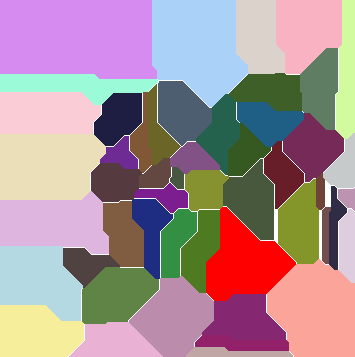

In [28]:
def process1(s, part2=False, max_sum=10_000, visualize=False):
  yxs = []
  for line in s.strip('\n').split('\n'):
    x, y = map(int, line.split(','))
    yxs.append((y, x))
  shape = np.max(yxs, axis=0) + 1

  def manhattan_from(yx):
    indices = np.indices(shape, dtype=np.int32)
    return abs(indices[0] - yx[0]) + abs(indices[1] - yx[1])

  all_manhattans = np.array([manhattan_from(yx) for yx in yxs])

  if not part2:
    closest = all_manhattans.argmin(axis=0)
    # min_manhattan = all_manhattans.min(axis=0)  # Same but a bit slower.
    min_manhattan = np.take_along_axis(all_manhattans, closest[None], axis=0)[0]
    count_min = np.count_nonzero(all_manhattans == min_manhattan, axis=0)
    closest[count_min > 1] = -1  # Disqualify equidistant locations.
    unbounded = (set(closest[0]) | set(closest[-1]) |
                 set(closest[:, 0]) | set(closest[:, -1]))
    counts = collections.Counter(closest.flat)
    count, i = max((c, i) for i, c in counts.items()
                   if i not in unbounded | {-1})
    if visualize:
      np.random.seed(0)
      cmap = np.uint8(np.random.choice(range(30, 150), (len(yxs) + 1, 3)))
      image = cmap[closest + 1]
      unb = (closest[..., None] == np.array(list(unbounded))).sum(axis=-1) > 0
      image[unb] += 105
      image[closest == -1] = (255, 255, 255)
      image[closest == i] = (255, 0, 0)
      media.show_image(image, height=max(40, shape[0]))
    return count

  sum_manhattans = all_manhattans.sum(axis=0)
  return np.count_nonzero(sum_manhattans < max_sum)

check_eq(process1(s1), 17)
puzzle.verify(1, process1)

_ = process1(puzzle.input, visualize=True)

In [29]:
process2 = functools.partial(process1, part2=True)
check_eq(process2(s1, max_sum=32), 16)
puzzle.verify(2, process2)

(Part 2: 0.077 s)


<a name="day7"></a>
## Day 7: Tasks with dependencies

- Part 1: In what order should the steps in your instructions be completed?

- Part 2: With 5 workers and the 60+ second step durations described above, how long will it take to complete all of the steps?

In [30]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2018/day/7), `puzzle.input` has 101 lines:

Step H must be finished before step C can begin.
Step R must be finished before step S can begin.
Step F must be finished before step M can begin.
Step S must be finished before step Z can begin.
Step X must be finished before step Z can begin.
Step Q must be finished before step G can begin.
Step M must be finished before step Z can begin.
Step G must be finished before step V can begin.
 ...
Step F must be finished before step C can begin.
Step B must be finished before step L can begin.
Step O must be finished before step T can begin.
Step S must be finished before step O can begin.


The stored answers are: `{1: 'FHMEQGIRSXNWZBCLOTUADJPKVY', 2: '917'}`

In [31]:
s1 = """
Step C must be finished before step A can begin.
Step C must be finished before step F can begin.
Step A must be finished before step B can begin.
Step A must be finished before step D can begin.
Step B must be finished before step E can begin.
Step D must be finished before step E can begin.
Step F must be finished before step E can begin.
"""

In [32]:
def process1(s, part2=False, num_workers=5, cost_base=60):
  dependencies = collections.defaultdict(set)
  nodes = set()
  for line in s.strip('\n').split('\n'):
    pattern = r'Step (.) must be finished before step (.) can begin\.'
    node1, node2 = re.fullmatch(pattern, line).groups()
    nodes |= {node1, node2}
    dependencies[node2].add(node1)
  nodelist = sorted(nodes)

  def get_next_node():
    for node in nodelist:
      if not dependencies[node]:
        nodelist.remove(node)
        return node
    return None

  def finish_node(node):
    for set_ in dependencies.values():
      set_ -= {node}

  if not part2:
    result = []
    while nodelist:
      node = get_next_node()
      result.append(node)
      finish_node(node)
    return ''.join(result)

  worker_node = [None] * num_workers
  worker_time = [0] * num_workers
  time = 0
  while True:
    for worker in range(num_workers):
      if worker_node[worker]:
        worker_time[worker] -= 1
        if not worker_time[worker]:
          finish_node(worker_node[worker])
          worker_node[worker] = None
    if not nodelist and not any(worker_node):
      break
    for worker in range(num_workers):
      if not worker_node[worker]:
        node = get_next_node()
        if node:
          worker_node[worker] = node
          worker_time[worker] = cost_base + 1 + ord(node) - ord('A')
    time += 1
  return time


check_eq(process1(s1), 'CABDFE')
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1, num_workers=2, cost_base=0), 15)
puzzle.verify(2, process2)

(Part 1: 0.000 s)
(Part 2: 0.004 s)


<a name="day8"></a>
## Day 8: Tree from preorder traversal

- Part 1: What is the sum of all metadata entries?

- Part 2: What is the computed value of the root node?

In [33]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2018/day/8), `puzzle.input` has 1 lines:

7 11 7 2 5 4 3 4 1 5 0 6 7 5 5 8 1 4 1 1 1 1 1 1 9 0 8 4 8 6 4 1 1 3 6 3 3 2 2 1 ... 2 4 6 1 7 4 6 3 6 9 7 7 5 4 6 7 4 2


The stored answers are: `{1: '36027', 2: '23960'}`

In [34]:
def process1(s, part2=False):

  @dataclasses.dataclass
  class TreeNode:
    children: List['TreeNode']
    metadatas: List[int]

  values = map(int, s.split())

  def parse_tree():
    node = TreeNode([], [])
    num_children = next(values)
    num_metadatas = next(values)
    for _ in range(num_children):
      node.children.append(parse_tree())
    for _ in range(num_metadatas):
      node.metadatas.append(next(values))
    return node

  tree = parse_tree()
  assert next(values, None) is None

  def sum_metadata(node):
    return sum(sum_metadata(n) for n in node.children) + sum(node.metadatas)

  if not part2:
    return sum_metadata(tree)

  def node_value(node):
    if not node.children:
      return sum(node.metadatas)
    return sum(node_value(node.children[child_index - 1])
               for child_index in node.metadatas
               if 1 <= child_index <= len(node.children))

  return node_value(tree)

check_eq(process1('2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2'), 138)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2('2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2'), 66)
puzzle.verify(2, process2)

(Part 1: 0.010 s)
(Part 2: 0.010 s)


<a name="day9"></a>
## Day 9: Circle of marbles

- Part 1: What is the winning Elf's score?

- Part 2: What would the new winning Elf's score be if the number of the last marble were 100 times larger?

In [35]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2018/day/9), `puzzle.input` has 1 lines:

479 players; last marble is worth 71035 points


The stored answers are: `{1: '367634', 2: '3020072891'}`

In [36]:
def process1(s, part2=False):
  pattern = r'(\d+) players; last marble is worth (\d+) points'
  num_players, last_marble = map(int, re.fullmatch(pattern, s.strip()).groups())
  if part2:
    last_marble *= 100
  marbles = collections.deque([0])
  scores = [0] * num_players
  # Note that numba does not support deque; there is a feature request:
  # https://githubmemory.com/repo/numba/numba/issues/7417
  for marble in range(1, last_marble + 1):
    if marble % 23 == 0:
      marbles.rotate(7)
      marble1 = marbles.popleft()
      points = marble + marble1
      player = marble % num_players
      scores[player] += points
    else:
      marbles.rotate(-2)
      marbles.appendleft(marble)

  return max(scores)


check_eq(process1('10 players; last marble is worth 1618 points'), 8317)
check_eq(process1('13 players; last marble is worth 7999 points'), 146373)
check_eq(process1('17 players; last marble is worth 1104 points'), 2764)
check_eq(process1('21 players; last marble is worth 6111 points'), 54718)
check_eq(process1('30 players; last marble is worth 5807 points'), 37305)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.025 s)
(Part 2: 2.119 s)


<a name="day10"></a>
## Day 10: Message from moving points

- Part 1: What message will eventually appear in the sky?

- Part 2: how many seconds would they have needed to wait for that message to appear?

In [37]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2018/day/10), `puzzle.input` has 383 lines:

position=< 20247,  40241> velocity=<-2, -4>
position=< 10184, -29948> velocity=<-1,  3>
position=< 50313, -39966> velocity=<-5,  4>
position=<-19870, -19921> velocity=< 2,  2>
position=< 10224, -49995> velocity=<-1,  5>
position=<-19904,  20191> velocity=< 2, -2>
position=< 50300,  -9887> velocity=<-5,  1>
position=<-29924, -29942> velocity=< 3,  3>
 ...
position=< -9838,  30214> velocity=< 1, -3>
position=< 50305,  50269> velocity=<-5, -5>
position=<-49933,  -9891> velocity=< 5,  1>
position=< 50321,  30215> velocity=<-5, -3>


The stored answers are: `{1: 'FPRBRRZA', 2: '10027'}`

In [38]:
s1 = """
position=< 9,  1> velocity=< 0,  2>
position=< 7,  0> velocity=<-1,  0>
position=< 3, -2> velocity=<-1,  1>
position=< 6, 10> velocity=<-2, -1>
position=< 2, -4> velocity=< 2,  2>
position=<-6, 10> velocity=< 2, -2>
position=< 1,  8> velocity=< 1, -1>
position=< 1,  7> velocity=< 1,  0>
position=<-3, 11> velocity=< 1, -2>
position=< 7,  6> velocity=<-1, -1>
position=<-2,  3> velocity=< 1,  0>
position=<-4,  3> velocity=< 2,  0>
position=<10, -3> velocity=<-1,  1>
position=< 5, 11> velocity=< 1, -2>
position=< 4,  7> velocity=< 0, -1>
position=< 8, -2> velocity=< 0,  1>
position=<15,  0> velocity=<-2,  0>
position=< 1,  6> velocity=< 1,  0>
position=< 8,  9> velocity=< 0, -1>
position=< 3,  3> velocity=<-1,  1>
position=< 0,  5> velocity=< 0, -1>
position=<-2,  2> velocity=< 2,  0>
position=< 5, -2> velocity=< 1,  2>
position=< 1,  4> velocity=< 2,  1>
position=<-2,  7> velocity=< 2, -2>
position=< 3,  6> velocity=<-1, -1>
position=< 5,  0> velocity=< 1,  0>
position=<-6,  0> velocity=< 2,  0>
position=< 5,  9> velocity=< 1, -2>
position=<14,  7> velocity=<-2,  0>
position=<-3,  6> velocity=< 2, -1>
"""

In [39]:
# "Support for 10-pixel-tall characters (2018 Day 10) is coming soon."
if 0:  # https://pypi.org/project/advent-of-code-ocr/
  !pip -q install advent-of-code-ocr
  import advent_of_code_ocr

In [40]:
def process1(s, part2=False):
  positions, velocities = [], []
  for line in s.strip('\n').split('\n'):
    pattern = r'position=< *(\S+), *(\S+)> velocity=< *(\S+), *(\S+)>'
    x, y, dx, dy = map(int, re.fullmatch(pattern, line).groups())
    positions.append([y, x])
    velocities.append([dy, dx])
  positions, velocities = np.array(positions), np.array(velocities)

  for index in itertools.count():
    shape = np.ptp(positions, axis=0) + 1
    if shape[0] == 8 or (shape[0] == 10 and shape[1] > 30):
      break
    positions += velocities

  if part2:
    return index

  grid = hh.grid_from_indices(positions, dtype=np.uint8)
  media.show_image(grid, height=80, border=True)
  import hashlib
  hashed = hashlib.md5(''.join(map(str, grid.flat)).encode()).hexdigest()
  print(hashed)
  return {
      '05d005c2fd38c74568ab697305825ff6': 'FPRBRRZA',  # google.Hugues_Hoppe.965276
      '7a115ac723c75059c742c8bb21d5ee1c': 'ERCXLAJL',  # github.hhoppe.1452460
  }[hashed] if shape[1] > 30 else 'HI'

check_eq(process1(s1), 'HI')
puzzle.verify(1, process1)

""


3e15ee7d01913ad958fd6efb03c9db5e


""


05d005c2fd38c74568ab697305825ff6
(Part 1: 0.270 s)


In [41]:
process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 3)
puzzle.verify(2, process2)

(Part 2: 0.267 s)


<a name="day11"></a>
## Day 11: Grid square with largest sum

- Part 1: What is the `X,Y` coordinate of the top-left fuel cell of the 3x3 square with the largest total power?

- Part 2: What is the `X,Y,size` identifier of the square with the largest total power?

In [42]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2018/day/11), `puzzle.input` has 1 lines:

9005


The stored answers are: `{1: '20,32', 2: '235,287,13'}`

In [43]:
def process1(s, part2=False):

  def power_level(yx, serial_number):
    rack_id = yx[1] + 10
    return ((rack_id * yx[0] + serial_number) * rack_id // 100) % 10 - 5

  check_eq(power_level([5, 3], serial_number=8), 4)
  check_eq(power_level([79, 122], serial_number=57), -5)
  check_eq(power_level([196, 217], serial_number=39), 0)
  check_eq(power_level([153, 101], serial_number=71), 4)

  serial_number = int(s)
  shape = (300, 300)
  indices = np.indices(shape, np.int32)
  power = power_level(indices + 1, serial_number=serial_number)
  integral = np.pad(power, [[1, 0], [1, 0]]).cumsum(axis=0).cumsum(axis=1)

  def get_yx_largest(size):
    if 0:  # Slower.
      import scipy.signal
      box = np.full((size, size), 1, dtype=np.int32)
      result = scipy.signal.convolve2d(power, box, mode='valid')
    else:
      result = (integral[size:, size:] - integral[size:, :-size]
                - integral[:-size, size:] + integral[:-size, :-size])
    yx_largest = np.unravel_index(result.argmax(), result.shape)
    largest = result[yx_largest]
    return yx_largest, largest

  if not part2:
    yx_largest = get_yx_largest(size=3)[0]
    return f'{yx_largest[1] + 1},{yx_largest[0] + 1}'

  results = {size: get_yx_largest(size) for size in range(1, 301)}
  best_size = max(results, key=lambda size: results[size][1])
  yx_largest = results[best_size][0]
  return f'{yx_largest[1] + 1},{yx_largest[0] + 1},{best_size}'


check_eq(process1('18'), '33,45')
check_eq(process1('42'), '21,61')
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2('18'), '90,269,16')
check_eq(process2('42'), '232,251,12')
puzzle.verify(2, process2)

(Part 1: 0.003 s)
(Part 2: 0.071 s)


<a name="day12"></a>
## Day 12: Cellular automaton in 1D

- Part 1: After 20 generations, what is the sum of the numbers of all pots which contain a plant?

- Part 2: After fifty billion (50000000000) generations, what is the sum of the numbers of all pots which contain a plant?

In [44]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2018/day/12), `puzzle.input` has 34 lines:

initial state: ###.#..#..##.##.###.#.....#.#.###.#.####....#.##..#.#.#..#....##..#.##...#.###.#.#..#..####.#.##.#

#.... => .
#.##. => #
..#.. => .
#.#.# => .
.#.## => #
...## => #
 ...
.#..# => #
.#### => .
##### => #
##.## => #


The stored answers are: `{1: '2909', 2: '2500000001175'}`

In [45]:
s1 = """
initial state: #..#.#..##......###...###

...## => #
..#.. => #
.#... => #
.#.#. => #
.#.## => #
.##.. => #
.#### => #
#.#.# => #
#.### => #
##.#. => #
##.## => #
###.. => #
###.# => #
####. => #
"""

In [46]:
def sliding_window(iterable, n):
  # sliding_window('ABCDEFG', 4) -> ABCD BCDE CDEF DEFG
  it = iter(iterable)
  window = collections.deque(itertools.islice(it, n), maxlen=n)
  if len(window) == n:
    yield tuple(window)
  for x in it:
    window.append(x)
    yield tuple(window)


def process1(s, num_generations=20, pad_len=25, part2=False):
  lines = s.strip('\n').split('\n')
  assert lines[0].startswith('initial state: ') and not lines[1]
  state = lines[0][15:]
  rules = {''.join(key): '.' for key in itertools.product('.#', repeat=5)}
  for line in lines[2:]:
    key, value = line.split(' => ')
    rules[key] = value
  state = '.' * pad_len + state + '.' * pad_len

  sum_pots = []
  for index in range(num_generations):
    state = ('..' + ''.join(rules[''.join(window)]
                            for window in sliding_window(state, 5)) + '..')
    sum_pots.append(sum(i - pad_len for i, ch in enumerate(state) if ch == '#'))

  if not part2:
    return sum_pots[-1]

  # Visually, after 110 generations, it has converged to a constant pattern
  # that is translating rightwards by 1 space every generation.
  diff = np.diff(sum_pots[-10:])
  assert np.all(diff == diff[-1])
  remaining_generations = 50000000000 - num_generations
  return sum_pots[-1] + diff[-1] * remaining_generations


check_eq(process1(s1), 325)
puzzle.verify(1, process1)

process2 = functools.partial(
    process1, part2=True, pad_len=200, num_generations=150)
puzzle.verify(2, process2)

(Part 1: 0.003 s)
(Part 2: 0.051 s)


<a name="day13"></a>
## Day 13: Carts on tracks

- Part 1: What is the `x,y` location of the first crash?

- Part 2: What is the location of the last cart at the end of the first tick where it is the only cart left?

In [47]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2018/day/13), `puzzle.input` has 150 lines:

                                  /----------------------------\                 ...                                    
  /-------------------------------+----------------------------+---------------- ...                                    
  |                               |                            |                 ... ---------------------\             
  |               /---------------+----------------------------+---------------- ...                      |             
  |  /------------+------------\  |                            |                 ... ---------------\     |             
  |  |            |            |  |                            |                 ...          /-----+---\ |             
  |  |        /---+------------+--+-------------------------\  |/--------------- ...          |     |   | |             
  |  |        |   |        /---+--+-------------------------+--++--------------- ... --\      |  /--+---+-+------\      
 ...
           |       \---+---

The stored answers are: `{1: '80,100', 2: '16,99'}`

In [48]:
s1 = r"""
/->-\        
|   |  /----\
| /-+--+-\  |
| | |  | v  |
\-+-/  \-+--/
  \------/   
"""

first collision at iteration=13
first collision at iteration=135
(Part 1: 0.041 s)


""

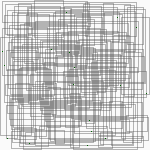

In [49]:
def process1(s, part2=False, verbose=False, visualize=False):

  @dataclasses.dataclass
  class Cart:
    yx: Tuple[int, int]
    direction: str  # '<', '>', 'v', or '^'.
    next_turn: int = 0  # Three states: 0=left, 1=straight, 2=right.

  grid = hh.grid_from_string(s)
  carts = []
  for ch in '<>v^':
    for yx in zip(*np.nonzero(grid == ch)):
      grid[yx] = {'<': '-', '>': '-', 'v': '|', '^': '|'}[ch]
      carts.append(Cart(yx, ch))

  def text_from_grid():
    grid2 = grid.copy()
    for cart in carts:
      grid2[cart.yx] = cart.direction
    return hh.string_from_grid(grid2)

  check_eq(text_from_grid(), s.strip('\n'))

  def show():
    video = images + images[-1:] * 10
    media.show_video(video, codec='gif', fps=20, height=grid.shape[0] * 3)

  images = []
  for iteration in itertools.count():
    assert len(carts) >= 2
    if visualize:
      cmap = {' ': (250,) * 3, '+': (140, 140, 140),
              **{ch: (180,)* 3 for ch in r'|-\/'}}
      image = np.array([cmap[e] for e in grid.ravel()], dtype=np.uint8)
      image = image.reshape(*grid.shape, 3)
      for cart in carts:
        image[cart.yx] = (0, 100, 0)
      images.append(image)
    if verbose:
      print(text_from_grid())
    for cart in sorted(carts, key=lambda cart: cart.yx):
      if cart.yx[0] == -1:
        continue
      dyx = {'<': (0, -1), '>': (0, 1),
             '^': (-1, 0), 'v': (1, 0)}[cart.direction]
      new_yx = tuple(np.array(cart.yx) + dyx)
      cart2 = next((cart2 for cart2 in carts if cart2.yx == new_yx), None)
      if cart2:  # Collison.
        if not part2:
          if visualize:
            return show()
          else:
            print(f'first collision at iteration={iteration}')
            return f'{new_yx[1]},{new_yx[0]}'
        for crashed_cart in [cart, cart2]:
          crashed_cart.yx = (-1, -1)
        continue
      ch = grid[new_yx]
      assert ch in '/\\+-|', ord(ch)
      if ch in '/\\':
        cart.direction = {
            '</': 'v', '<\\': '^', '>/': '^', '>\\': 'v',
            '^/': '>', '^\\': '<', 'v/': '<', 'v\\': '>',
        }[cart.direction + ch]
      elif ch == '+':
        if cart.next_turn in (0, 2):
          cart.direction = {
              '<0': 'v', '<2': '^', '>0': '^', '>2': 'v',
              '^0': '<', '^2': '>', 'v0': '>', 'v2': '<',
          }[cart.direction + str(cart.next_turn)]
        cart.next_turn = (cart.next_turn + 1) % 3
      cart.yx = new_yx
    carts = [cart for cart in carts if cart.yx[0] != -1]
    if part2 and len(carts) == 1:
      print(f'Only one cart left at iteration={iteration}')
      return f'{carts[0].yx[1]},{carts[0].yx[0]}'


check_eq(process1(s1), '7,3')
puzzle.verify(1, process1)
if media.video_is_available():
  process1(puzzle.input, visualize=True)

In [50]:
s2 = r"""
/>-<\  
|   |  
| /<+-\
| | | v
\>+</ |
  |   ^
  \<->/
"""

In [51]:
process2 = functools.partial(process1, part2=True)
check_eq(process2(s2), '6,4')
puzzle.verify(2, process2)

Only one cart left at iteration=2
Only one cart left at iteration=16987
(Part 2: 0.658 s)


<a name="day14"></a>
## Day 14: Combining recipes

- Part 1: What are the scores of the ten recipes immediately after the number of recipes in your puzzle input?

- Part 2: How many recipes appear on the scoreboard to the left of the score sequence in your puzzle input?

In [52]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2018/day/14), `puzzle.input` has 1 lines:

702831


The stored answers are: `{1: '1132413111', 2: '20340232'}`

In [53]:
def process1(s):  # Slow: 0.9 s.
  num_recipes = int(s)
  recipes = [3, 7]
  indices = [0, 1]

  while len(recipes) < num_recipes + 10:
    currents = [recipes[index] for index in indices]
    total = sum(currents)
    digits = [1, total - 10] if total >= 10 else [total]
    recipes.extend(digits)
    indices = [(index + 1 + recipes[index]) % len(recipes) for index in indices]

  return ''.join(map(str, recipes[num_recipes:num_recipes + 10]))


check_eq(process1('9'), '5158916779')
check_eq(process1('5'), '0124515891')
check_eq(process1('18'), '9251071085')
check_eq(process1('2018'), '5941429882')
puzzle.verify(1, process1)

(Part 1: 0.929 s)


In [54]:
def process1(s):  # Fast using numba.
  num_recipes = int(s)

  @numba_njit
  def func():
    recipes = np.empty(num_recipes + 11, dtype=np.uint8)
    num = 2
    recipes[0] = 3
    recipes[1] = 7
    index0, index1 = 0, 1
    while num < num_recipes + 10:
      current0, current1 = recipes[index0], recipes[index1]
      total = current0 + current1
      if total >= 10:
        recipes[num] = 1
        recipes[num + 1] = total - 10
        num += 2
      else:
        recipes[num] = total
        num += 1
      index0 = (index0 + 1 + current0) % num
      index1 = (index1 + 1 + current1) % num
    return recipes[num_recipes:num_recipes + 10]

  return ''.join(map(str, func()))


check_eq(process1('9'), '5158916779')
check_eq(process1('5'), '0124515891')
check_eq(process1('18'), '9251071085')
check_eq(process1('2018'), '5941429882')
puzzle.verify(1, process1)  # ~0.2 s.

(Part 1: 0.333 s)


In [55]:
def process2(s):  # Slow: 30 s.
  pattern = list(map(int, s.strip()))
  recipes = [3, 7]
  indices = [0, 1]

  while True:
    currents = [recipes[index] for index in indices]
    total = sum(currents)
    digits = [1, total - 10] if total >= 10 else [total]
    for digit in digits:
      recipes.append(digit)
      if recipes[-len(pattern):] == pattern:
        return len(recipes) - len(pattern)
    indices = [(index + 1 + recipes[index]) % len(recipes) for index in indices]

In [56]:
def process2(s):  # Fast using numba.
  pattern = tuple(int(ch) for ch in s.strip())
  len_pattern = len(pattern)

  @numba_njit
  def func():
    recipes = [3, 7]
    index0, index1 = 0, 1
    while True:
      current0 = recipes[index0]
      current1 = recipes[index1]
      total = current0 + current1
      if total >= 10:
        recipes.append(1)
        if len(recipes) >= len_pattern:
          for i in range(-len_pattern, 0):
            if recipes[i] != pattern[i]:
              break
          else:
            break
        recipes.append(total - 10)
        if len(recipes) >= len_pattern:
          for i in range(-len_pattern, 0):
            if recipes[i] != pattern[i]:
              break
          else:
            break
      else:
        recipes.append(total)
        if len(recipes) >= len_pattern:
          for i in range(-len_pattern, 0):
            if recipes[i] != pattern[i]:
              break
          else:
            break
      index0 = (index0 + 1 + current0) % len(recipes)
      index1 = (index1 + 1 + current1) % len(recipes)

    return len(recipes) - len_pattern

  return func()


check_eq(process2('51589'), 9)
check_eq(process2('01245'), 5)
check_eq(process2('92510'), 18)
check_eq(process2('59414'), 2018)
puzzle.verify(2, process2)  # ~1.2 s

(Part 2: 1.419 s)


<a name="day15"></a>
## Day 15: Combat simulation

- Part 1: What is the outcome of the combat described in your puzzle input?

- Part 2: After increasing the Elves' attack power until it is just barely enough for them to win without any Elves dying, what is the outcome of the combat described in your puzzle input?

In [57]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2018/day/15), `puzzle.input` has 32 lines:

################################
#########.######################
#########..#####################
#########..G####################
########....#GG#################
########G......#################
########........################
###.####...#....################
 ...
####...###..#..#######.......###
####...###############.#########
#####..#########################
################################


The stored answers are: `{1: '269430', 2: '55160'}`

In [58]:
s1 = """
#######
#.G...#
#...EG#
#.#.#G#
#..G#E#
#.....#
#######
"""

s10 = """
#######
#G..#E#
#E#E.E#
#G.##.#
#...#E#
#...E.#
#######
"""

s11 = """
#######
#E..EG#
#.#G.E#
#E.##E#
#G..#.#
#..E#.#
#######
"""

s12 = """
#######
#E.G#.#
#.#G..#
#G.#.G#
#G..#.#
#...E.#
#######
"""

s13 = """
#######
#.E...#
#.#..G#
#.###.#
#E#G#G#
#...#G#
#######
"""

s14 = """
#########
#G......#
#.E.#...#
#..##..G#
#...##..#
#...#...#
#.G...G.#
#.....G.#
#########
"""

(Part 1: 0.916 s)


""

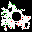

In [59]:
def simulate_combat(s, verbose=False, visualize=False,
                    elf_attack_power=3, fail_if_elf_dies=False):

  @dataclasses.dataclass
  class Unit:
    yx: Tuple[int, int]
    ch: str  # 'E' (Elf) or 'G' (Goblin).
    hit_points: int = 200

  show = hh.show if verbose else lambda *a, **k: None
  grid = hh.grid_from_string(s)
  units = [Unit(yx, ch) for ch in 'GE' for yx in zip(*np.nonzero(grid == ch))]

  def get_opponents(unit):
    return (u for u in units if u.ch != unit.ch)

  def manhattan(yx1, yx2):
    return abs(yx1[0] - yx2[0]) + abs(yx1[1] - yx2[1])

  def get_adjacent_opponents(unit):
    return [u for u in get_opponents(unit) if manhattan(u.yx, unit.yx) == 1]

  def empty_adjacent_yxs(yx):
    y, x = yx
    for yx2 in ((y - 1, x), (y, x - 1), (y + 1, x), (y, x + 1)):
      # Bounds checking is unnecessary because maze is surrounded by walls.
      if grid[yx2] == '.':
        yield yx2

  images = []
  for round in itertools.count():
    if visualize:
      cmap = {'.': (250,) * 3, '#': (0, 0, 0),
              'E': (255, 0, 0), 'G': (0, 190, 0)}
      image = np.array([cmap[e] for e in grid.ravel()], dtype=np.uint8)
      image = image.reshape(*grid.shape, 3)
      images.append(image)
    hit_points = [u.hit_points for u in sorted(units, key=lambda u: u.yx)]
    show('\nBegin round', round, hit_points)
    show('' + hh.string_from_grid(grid))
    incomplete_round = False
    for unit in sorted(units, key=lambda unit: unit.yx):
      if unit not in units:  # If already deleted, skip it.
        continue
      if len(set(u.ch for u in units)) == 1:
        incomplete_round = True  # Unit cannot attack, so end of combat.
        break

      # Find nearest attacker-adjacent position and try to move towards it.
      adjacent_opponents = get_adjacent_opponents(unit)
      if not adjacent_opponents:
        inrange = {yx for u in get_opponents(unit)
                   for yx in empty_adjacent_yxs(u.yx)}
        if not inrange:  # No accessible opponent.
          continue

        # BFS from unit until yx in inrange; record all others at same distance.
        distances = {unit.yx: 0}
        queue = collections.deque([unit.yx])
        nearests = set()
        while queue:
          yx = queue.popleft()
          d_yx = distances[yx]
          if nearests and d_yx >= distances[next(iter(nearests))]:
            break
          for yx2 in empty_adjacent_yxs(yx):
            if yx2 not in distances:
              distances[yx2] = d_yx + 1
              queue.append(yx2)
              if yx2 in inrange:
                nearests.add(yx2)
        if not nearests:  # No path to opponent.
          continue
        nearest = min(nearests)
        nearest_distance = distances[nearest]
        assert all(distances[yx] == nearest_distance for yx in nearests)

        # BFS from nearest to unit; find unit neighbor with shortest distance.
        distances = {nearest: 0}
        queue = collections.deque([nearest])
        while True:
          yx = queue.popleft()
          d_yx = distances[yx]
          if d_yx >= nearest_distance - 1:
            break
          for yx2 in empty_adjacent_yxs(yx):
            if yx2 not in distances:
              if d_yx + manhattan(yx2, unit.yx) <= nearest_distance:  # A*.
                distances[yx2] = d_yx + 1
                queue.append(yx2)
        best_adjacent = min(empty_adjacent_yxs(unit.yx),
                            key=lambda yx: (distances.get(yx, math.inf), yx))
        check_eq(grid[unit.yx], unit.ch)
        check_eq(grid[best_adjacent], '.')
        check_eq(manhattan(best_adjacent, unit.yx), 1)
        grid[unit.yx] = '.'
        grid[best_adjacent] = unit.ch
        unit.yx = best_adjacent
        adjacent_opponents = get_adjacent_opponents(unit)

      # Find adjacent opponent with lowest hit points and attack it.
      if adjacent_opponents:
        opponent = min(adjacent_opponents, key=lambda u: (u.hit_points, u.yx))
        attack_power = elf_attack_power if unit.ch == 'E' else 3
        opponent.hit_points -= attack_power
        if opponent.hit_points <= 0:
          check_eq(grid[opponent.yx], opponent.ch)
          grid[opponent.yx] = '.'
          units.remove(opponent)
          if fail_if_elf_dies and opponent.ch == 'E':
            return None
    if incomplete_round:
      break

  if visualize:
    media.show_video(images, codec='gif', fps=10, height=grid.shape[0] * 5)
    return None
  num_rounds = round
  hit_points = [u.hit_points for u in sorted(units, key=lambda u: u.yx)]
  sum_points = sum(hit_points)
  show(num_rounds, sum_points, hit_points)
  show('' + hh.string_from_grid(grid))
  return num_rounds * sum_points

process1 = simulate_combat

check_eq(process1(s1), 27730)
check_eq(process1(s10), 36334)
check_eq(process1(s11), 39514)
check_eq(process1(s12), 27755)
check_eq(process1(s13), 28944)
check_eq(process1(s14), 18740)

puzzle.verify(1, process1)  # ~0.9 s.
if media.video_is_available():
  process1(puzzle.input, visualize=True)

In [60]:
def process2(s):  # Brute-force search of increasing attack power.
  for elf_attack_power in itertools.count(3):
    result = simulate_combat(
        s, elf_attack_power=elf_attack_power, fail_if_elf_dies=True)
    if result:
      print(f'Found solution at elf_attack_power={elf_attack_power}')
      return result

check_eq(process2(s1), 4988)
check_eq(process2(s11), 31284)
check_eq(process2(s12), 3478)
check_eq(process2(s13), 6474)
check_eq(process2(s14), 1140)

# puzzle.verify(2, process2)  # Slow; ~9 s.

Found solution at elf_attack_power=15
Found solution at elf_attack_power=4
Found solution at elf_attack_power=15
Found solution at elf_attack_power=12
Found solution at elf_attack_power=34


In [61]:
def process2(s):  # Faster bisection search.
  current = 10
  low = high = None
  results = {}
  while True:
    results[current] = result = simulate_combat(
        s, elf_attack_power=current, fail_if_elf_dies=True)
    if result:  # We should try to decrease current.
      high = current
      if low is None:
        current = current // 2
      elif low < current - 1:
        current = (low + high) // 2
      else:
        break
    else:  # We need to increase current.
      low = current
      if high is None:
        current = current * 2
      elif current < high - 1:
        current = (low + high) // 2
      else:
        current = current + 1
        break
  print(f'Found solution at elf_attack_power={current}')
  return results[current]

check_eq(process2(s1), 4988)
check_eq(process2(s11), 31284)
check_eq(process2(s12), 3478)
check_eq(process2(s13), 6474)
check_eq(process2(s14), 1140)

puzzle.verify(2, process2)  # ~1.9 s.
# (elf_attack_power = 19; num_rounds = 40)

Found solution at elf_attack_power=15
Found solution at elf_attack_power=4
Found solution at elf_attack_power=15
Found solution at elf_attack_power=12
Found solution at elf_attack_power=34
Found solution at elf_attack_power=19
(Part 2: 1.894 s)


In [62]:
if 0:
  def empty_adjacent_yxs(yx):  # Slow; bottleneck.
    for dyx in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
      yx2 = (yx[0] + dyx[0], yx[1] + dyx[1])
      if (0 <= yx2[0] < grid.shape[0] and 0 <= yx2[1] < grid.shape[1] and
          grid[yx2] == '.'):
        yield yx2

  def empty_adjacent_yxs(yx):
    y, x = yx
    yxa, yxb, yxc, yxd = (y - 1, x), (y, x - 1), (y + 1, x), (y, x + 1)
    result = []
    if y > 0 and grid[yxa] == '.': result.append(yxa)
    if x > 0 and grid[yxb] == '.': result.append(yxb)
    if yxc[0] < grid.shape[0] and grid[yxc] == '.': result.append(yxc)
    if yxd[1] < grid.shape[1] and grid[yxd] == '.': result.append(yxd)
    return result

  def empty_adjacent_yxs(yx):
    y, x = yx
    yxa, yxb, yxc, yxd = (y - 1, x), (y, x - 1), (y + 1, x), (y, x + 1)
    # e = [(x, x) for x in range(0)]  # Let numba know the list's type.
    return (([yxa] if y > 0 and grid[yxa] == '.' else []) +
            ([yxb] if x > 0 and grid[yxb] == '.' else []) +
            ([yxc] if yxc[0] < grid.shape[0] and grid[yxc] == '.' else []) +
            ([yxd] if yxd[1] < grid.shape[1] and grid[yxd] == '.' else []))

  def empty_adjacent_yxs(yx):
    y, x = yx
    yxa, yxb, yxc, yxd = (y - 1, x), (y, x - 1), (y + 1, x), (y, x + 1)
    return (((yxa,) if y > 0 and grid[yxa] == '.' else ()) +
            ((yxb,) if x > 0 and grid[yxb] == '.' else ()) +
            ((yxc,) if yxc[0] < grid.shape[0] and grid[yxc] == '.' else ()) +
            ((yxd,) if yxd[1] < grid.shape[1] and grid[yxd] == '.' else ()))

<a name="day16"></a>
## Day 16: Inferring opcodes

- Part 1: How many samples in your puzzle input behave like three or more opcodes?

- Part 2: What value is contained in register 0 after executing the test program?

In [63]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2018/day/16), `puzzle.input` has 4190 lines:

Before: [1, 0, 2, 1]
2 3 2 0
After:  [1, 0, 2, 1]

Before: [1, 0, 2, 2]
11 3 2 1
After:  [1, 0, 2, 2]

 ...
5 2 3 2
5 2 1 2
13 3 2 3
2 3 3 0


The stored answers are: `{1: '677', 2: '540'}`

In [64]:
s1 = """
Before: [3, 2, 1, 1]
9 2 1 2
After:  [3, 2, 2, 1]
"""

In [65]:
def process1(s, part2=False):
  s1, s2 = s.split('\n\n\n')
  machine = Machine(num_registers=4)
  num_operations = len(machine.operations)
  candidates = {op: set(range(num_operations)) for op in machine.operations}
  num_compatible_with_3_or_more = 0
  examples = s1.strip('\n').split('\n\n')
  for example in examples:
    lines = example.split('\n')
    check_eq(len(lines), 3)
    before = list(map(int, lines[0][9:-1].split(',')))
    codes = list(map(int, lines[1].split()))
    after = list(map(int, lines[2][9:-1].split(',')))
    check_eq(len(codes), 4)
    opcode, *operands = codes
    assert 0 <= opcode < num_operations
    num_compatible = 0
    for operation in machine.operations:
      registers = before.copy()
      machine.operations[operation](registers, operands)
      if registers == after:
        num_compatible += 1
      else:
        candidates[operation] -= {opcode}
    num_compatible_with_3_or_more += num_compatible >= 3

  if not part2:
    return num_compatible_with_3_or_more

  operation_from_opcode = {}
  while candidates:
    operation = next(op for op, set_ in candidates.items() if len(set_) == 1)
    opcode, = candidates.pop(operation)
    operation_from_opcode[opcode] = operation
    for set_ in candidates.values():
      set_ -= {opcode}
  print(operation_from_opcode)

  machine = Machine(num_registers=4)
  for line in s2.strip('\n').split('\n'):
    codes = list(map(int, line.split()))
    check_eq(len(codes), 4)
    opcode, *operands = codes
    operation = operation_from_opcode[opcode]
    machine.operations[operation](machine.registers, operands)

  return machine.registers[0]


check_eq(process1(s1 + '\n\n\n'), 1)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.020 s)
{4: 'bori', 7: 'borr', 13: 'addr', 10: 'addi', 5: 'muli', 14: 'mulr', 2: 'setr', 15: 'seti', 6: 'bani', 0: 'banr', 8: 'gtir', 12: 'eqri', 1: 'eqrr', 11: 'gtri', 3: 'eqir', 9: 'gtrr'}
(Part 2: 0.024 s)


<a name="day17"></a>
## Day 17: Water falling over reservoirs

- Part 1: How many tiles can the water reach within the range of y values in your scan?

- Part 2: How many water tiles are left after the water spring stops producing water and all remaining water not at rest has drained?

In [66]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2018/day/17), `puzzle.input` has 2130 lines:

x=360, y=75..98
x=579, y=819..844
y=1262, x=362..366
x=573, y=1593..1621
y=1546, x=508..510
x=284, y=1687..1696
y=1793, x=383..386
x=506, y=254..256
 ...
x=443, y=587..600
x=509, y=504..507
x=300, y=1481..1490
x=628, y=1443..1445


The stored answers are: `{1: '35707', 2: '29293'}`

In [67]:
s1 = """
x=495, y=2..7
y=7, x=495..501
x=501, y=3..7
x=498, y=2..4
x=506, y=1..2
x=498, y=10..13
x=504, y=10..13
y=13, x=498..504
"""

(Part 1: 0.126 s)


(transposed)

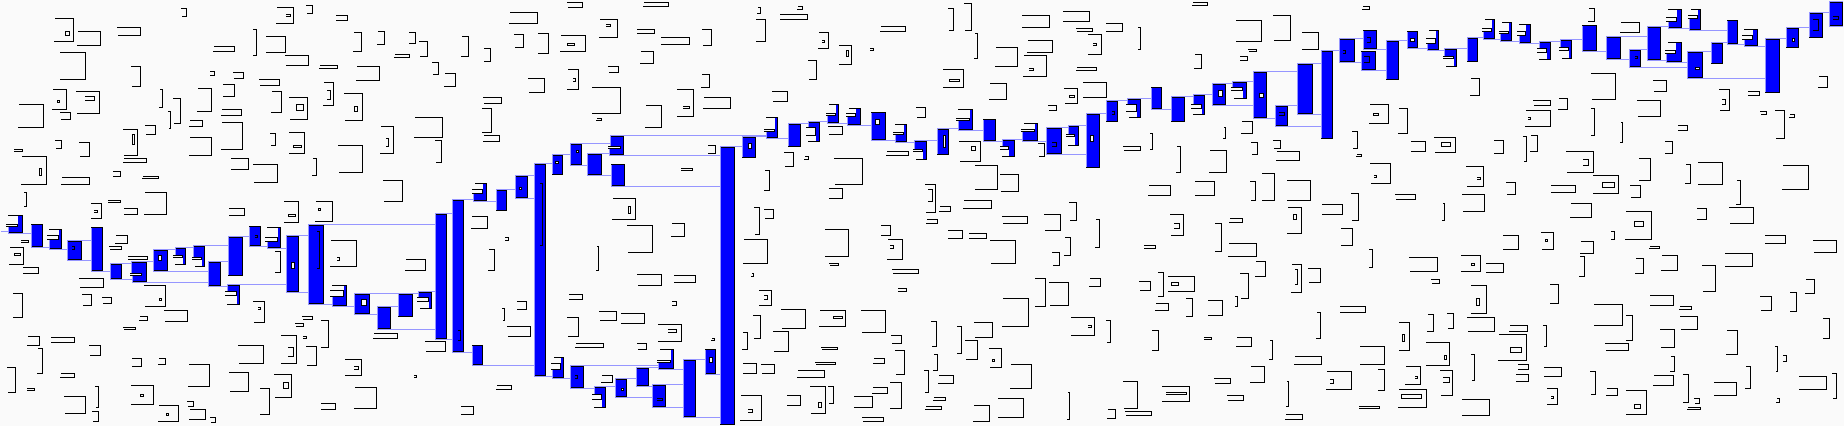

(Part 2: 0.113 s)


In [68]:
def process1(s, part2=False, visualize=False):
  grid = {}

  for line in s.strip('\n').split('\n'):
    pattern = r'[xy]=(\d+), [xy]=(\d+)\.\.(\d+)'
    x, y0, y1 = map(int, re.fullmatch(pattern, line).groups())
    for y in range(y0, y1 + 1):
      yx = (y, x) if line[0] == 'x' else (x, y)
      grid[yx[0], yx[1]] = '#'
  ymin, ymax = min(y for y, x in grid), max(y for y, x in grid)

  def encode(yx): return -yx[0], yx[1]
  def decode(yx): return -yx[0], yx[1]
  yx = 0, 500
  sources = [encode(yx)]  # heap
  grid[yx] = '|'

  while sources:
    yx = decode(sources[0])
    check_eq(grid[yx], '|')
    if yx[0] == ymax:
      heapq.heappop(sources)
      continue
    y1x = yx[0] + 1, yx[1]
    ch = grid.get(y1x, '.')
    if ch == '|':
      heapq.heappop(sources)
      continue
    if ch == '.':
      grid[y1x] = '|'
      heapq.heappush(sources, encode(y1x))
      continue
    assert ch in '~#'
    heapq.heappop(sources)
    bounded = []
    for dx in (-1, 1):
      yx2 = yx
      while True:
        yx2 = yx2[0], yx2[1] + dx
        ch2 = grid.get(yx2, '.')
        assert ch2 != '~'
        if ch2 == '#':
          bounded.append(yx2[1])
          break
        grid[yx2] = '|'
        y1x2 = yx2[0] + 1, yx2[1]
        if ch2 == '.' and y1x2 not in grid:
          heapq.heappush(sources, encode(yx2))
        if grid.get(y1x2, '.') not in '~#':
          break
    if len(bounded) == 2:
      for x in range(bounded[0] + 1, bounded[1]):
        grid[yx[0], x] = '~'

  if visualize:
    cmap = {'.': (250,) * 3, '#': (0, 0, 0),
            '~': (0, 0, 255), '|': (150, 150, 255)}
    image = hh.image_from_yx_map(grid, '.', cmap, pad=1).transpose(1, 0, 2)
    media.show_image(image, title='(transposed)', border=True)
    return None

  desired = '~' if part2 else '~|'
  return sum(1 for yx in grid if ymin <= yx[0] <= ymax and grid[yx] in desired)

check_eq(process1(s1), 57)
puzzle.verify(1, process1)
process1(puzzle.input, visualize=True)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 29)
puzzle.verify(2, process2)

<a name="day18"></a>
## Day 18: Cellular automaton

- Part 1: What will the total resource value of the lumber collection area be after 10 minutes?

- Part 2: What will the total resource value of the lumber collection area be after 1000000000 minutes?

In [69]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2018/day/18), `puzzle.input` has 50 lines:

|..|#.#|..|#|.##.#..|.#....|.||.#..##...#.#|...|..
|#.||.|...|#.....#|#.#..##|...##....|...#.#|..|.#.
|..|.#.#..|.###..#.|...##|.||...|#...|##..|.....#.
.|..#.#...#|.....#|.#.....#.##.#.....||..|.||#....
#...|..||..|.#|...#.|.#..||....#..#|.....|#.....#.
..|..#.#|.....|.#.|....#...#.#.#|#.#|#....|..#..#.
#....|......||..#.#.#|...#....#.|||.|#....|||.##..
.|.#...|#.#|#|.|....|.||#.|.#||..##.|....#||...|..
 ...
..|#....|..||..|#|.#.#|#.|#..||||.|..|..|.....#.#|
##.......##|...#.|......##..#.|...#.#|#..|...|..#.
|##.#...#.....#.#.|.........#.#|...#...|........||
|.......|........#.##..#.#.#..#..#|.|#|.||#|||...|


The stored answers are: `{1: '574200', 2: '211653'}`

In [70]:
s1 = """
.#.#...|#.
.....#|##|
.|..|...#.
..|#.....#
#.#|||#|#|
...#.||...
.|....|...
||...#|.#|
|.||||..|.
...#.|..|.
"""

(Part 1: 0.015 s)
(Part 2: 0.710 s)


Start,Cycling period=28

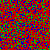
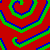

In [71]:
def process1(s, num_minutes=10, part2=False, visualize=False):
  grid = hh.grid_from_string(s)

  def evolve_grid():
    grid2 = np.pad(grid, 1, constant_values='.')
    yxs = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}
    neighbors = np.array([np.roll(grid2, yx, (0, 1))[1:-1, 1:-1] for yx in yxs])
    num_adjacent_trees = (neighbors == '|').sum(axis=0)
    num_adjacent_lumberyards = (neighbors == '#').sum(axis=0)
    old_grid = grid.copy()
    grid[(old_grid == '.') & (num_adjacent_trees >= 3)] = '|'
    grid[(old_grid == '|') & (num_adjacent_lumberyards >= 3)] = '#'
    grid[(old_grid == '#') & ((num_adjacent_trees < 1) |
                              (num_adjacent_lumberyards < 1))] = '.'

  def resource_value():
    num_trees = np.count_nonzero(grid == '|')
    num_lumberyards = np.count_nonzero(grid == '#')
    return num_trees * num_lumberyards

  if not part2:
    for minute in range(num_minutes):
      evolve_grid()
    return resource_value()

  # Detect a repeating cycle to speed up the evolution.
  images = []
  configs = {}  # hashed_grid -> remaining minute it first appeared.
  remaining_minutes = 1_000_000_000
  period = None
  for minute in itertools.count():
    if visualize:
      cmap = {'.': (200, 0, 0), '|': (0, 200, 0), '#': (0, 0, 200)}
      image = np.array([cmap[e] for e in grid.ravel()], dtype=np.uint8)
      image = image.reshape(*grid.shape, 3)
      images.append(image)
    config = ''.join(grid.flat)
    if config in configs and not period:
      period = configs[config] - remaining_minutes
      remaining_minutes = remaining_minutes % period
      # print(f'At minute {minute}, found cycle with period {period}.')
    if not remaining_minutes:
      break
    configs[config] = remaining_minutes
    evolve_grid()
    remaining_minutes -= 1

  if visualize:
    videos = {
        'Start': images[:50],
        f'Cycling period={period}': images[-period:],
    }
    media.show_videos(videos, codec='gif', fps=10, height=grid.shape[0] * 3)
    return None
  return resource_value()


check_eq(process1(s1), 1147)
# process1(puzzle.input, num_minutes=400)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)
if media.video_is_available():
  process2(puzzle.input, visualize=True)

<a name="day19"></a>
## Day 19: CPU with instruction pointer

- Part 1: What value is left in register 0 when the background process halts?

- Part 2: What value is left in register 0 when register 0 is started with the value 1?

In [72]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2018/day/19), `puzzle.input` has 37 lines:

#ip 3
addi 3 16 3
seti 1 0 4
seti 1 7 2
mulr 4 2 1
eqrr 1 5 1
addr 1 3 3
addi 3 1 3
 ...
mulr 1 3 1
addr 5 1 5
seti 0 0 0
seti 0 3 3


The stored answers are: `{1: '1430', 2: '14266944'}`

In [73]:
s1 = """
#ip 0
seti 5 0 1
seti 6 0 2
addi 0 1 0
addr 1 2 3
setr 1 0 0
seti 8 0 4
seti 9 0 5
"""

In [74]:
if 0:
  for i, line in enumerate(puzzle.input.splitlines()[1:17]):
    print(f'{i:2} {line}')

In [75]:
# Part 1:
# 0 (0, 0, 0, 16, 0, 0)
# 1 (0, 0, 0, 17, 0, 2)
# 2 (0, 0, 0, 18, 0, 4)
# 3 (0, 0, 0, 19, 0, 76)
# 4 (0, 0, 0, 20, 0, 836)
# 5 (0, 6, 0, 21, 0, 836)
# 6 (0, 132, 0, 22, 0, 836)
# 7 (0, 145, 0, 23, 0, 836)
# 8 (0, 145, 0, 24, 0, 981)
# 9 (0, 145, 0, 25, 0, 981)
# 10 (0, 145, 0, 0, 0, 981)  # func_ip1(a=0, f=981)
# ...
# 11 (0, 145, 0, 1, 1, 981)
# 12 (0, 145, 1, 2, 1, 981)
# 13 (0, 1, 1, 3, 1, 981)
# 14 (0, 0, 1, 4, 1, 981)
# 15 (0, 0, 1, 5, 1, 981)
# 16 (0, 0, 1, 7, 1, 981)
# 17 (0, 0, 2, 8, 1, 981)
# 18 (0, 0, 2, 9, 1, 981)
# 19 (0, 0, 2, 10, 1, 981)
# 20 (0, 0, 2, 2, 1, 981)
# ...
# 7702823 (1430, 1, 982, 256, 982, 981)

# Part 2:
# 18 (0, 10550400, 0, 0, 0, 10551381)  # func_ip1(a=0, f=10551381)

# Registers abcdef  (d=IP)
#  1 seti 1 0 4  e = 1
#  2 seti 1 7 2  c = 2
#  3 mulr 4 2 1  # b = e * c
#  4 eqrr 1 5 1
#  5 addr 1 3 3  if e * c == f goto 7
#  6 addi 3 1 3  goto 8
#  7 addr 4 0 0  a += e
#  8 addi 2 1 2  c += 1
#  9 gtrr 2 5 1
# 10 addr 3 1 3  if c > f goto 12
# 11 seti 2 6 3  goto 3
# 12 addi 4 1 4  e += 1
# 13 gtrr 4 5 1
# 14 addr 1 3 3  if e > f goto 16
# 15 seti 1 3 3  goto 2

# def func_ip1(a, f):
#   for e in range(1, f + 1):
#     for c in range(2, f + 1):
#       if e * c == f:
#         a += e

# def func_equivalent(a, f):
#   a += sum(e for e in range(1, f + 1) if f % e == 0)

# def func_equivalent2(a, f):
#   a += sum(factors(f))

In [76]:
def process1(s, part2=False, verbose=False):

  def factors(n):
    result = set()
    for i in range(1, int(n ** 0.5) + 1):
      div, mod = divmod(n, i)
      if mod == 0:
        result |= {i, div}
    return result

  machine = Machine()
  machine.read_instructions(s)
  optimize = len(machine.instructions) > 10
  if optimize:
    check_eq(machine.instructions[4].operation, 'eqrr')
    register_f = machine.instructions[4].operands[1]
    check_eq(machine.instructions[7].operation, 'addr')
    register_a = machine.instructions[7].operands[2]
  if part2:
    machine.registers[0] = 1
  history = []
  while 0 <= machine.ip < len(machine.instructions):
    if optimize and machine.ip == 1:
      # Unoptimized, part1 is slow (~8 s) and part2 is way too slow.
      f = machine.registers[register_f]
      machine.registers[register_a] += sum(factors(f))
      machine.ip = 16
    else:
      machine.run_instruction()
    history.append(tuple(machine.registers))
    if len(history) > 10_000_000:
      break

  if verbose:
    for i in range(min(200, len(history))):
      print(i, history[i])
    if len(history) > 200:
      for i in range(0, len(history), 100_000):
        print(i, history[i])
      for i in range(len(history) - 200, len(history)):
        print(i, history[i])

  return machine.registers[0]


check_eq(process1(s1), 6)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


<a name="day20"></a>
## Day 20: Regexp of doors in 2D map

- Part 1: What is the largest number of doors you would be required to pass through to reach a room?

- Part 2: How many rooms have a shortest path from your current location that pass through at least 1000 doors?

In [77]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2018/day/20), `puzzle.input` has 1 lines:

^SWWSWWWNNWSWSESWWWNWNNNNWWWSSSEE(NNWSNESS|)SSWNWSWWNENWNNE(NWWWSWWSEEE(N|SSWWN( ... ))|S)))|SES(WW|S)))|S)))|E)))))|S)$


The stored answers are: `{1: '3415', 2: '8583'}`

""


""


""


""


""


""

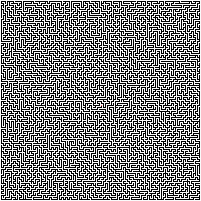

(Part 1: 1.012 s)


In [78]:
# I created a general solution, which can work on inputs that define
# passageways with 2D cycles.  However, it appears that all instances of the
# puzzle inputs give rise to a simple tree of passageways?
# In the case of a tree, can one simply look for the longest expansion of the
# regular expression?  No, it appears that the regexp expansions may involve
# backtracking along edges of the tree.  My solution is likely overkill for
# this simpler case.

def process1(s, part2=False, visualize=True):
  s, = re.fullmatch(r'\^([SNEW(|)]+)\$', s.strip()).groups()

  def parse(s):
    l = []
    while s and s[0] not in '|)':
      i = next((i for i, ch in enumerate(s) if ch in '(|)'), len(s))
      if i:
        l.append(s[:i])
        s = s[i:]
      else:
        check_eq(s[0], '(')
        l2 = []
        while s[0] != ')':
          l3, s = parse(s[1:])
          l2.append(l3)
          assert s[0] in '|)', s[0]
        l.append(l2)
        s = s[1:]
    return l, s

  l, _ = parse(s)

  def traverse(l):  # Returns three sets: doors_s, doors_e, yxs.
    if not l:
      return set(), set(), set()
    half = len(l) // 2
    if half:
      doors_s1, doors_e1, yxs1 = traverse(l[:half])
      doors_s2, doors_e2, yxs2 = traverse(l[half:])
      return (doors_s1 | {(y + v, x + u) for y, x in yxs1 for v, u in doors_s2},
              doors_e1 | {(y + v, x + u) for y, x in yxs1 for v, u in doors_e2},
              {(y + v, x + u) for y, x in yxs1 for v, u in yxs2})
    elem, = l
    if isinstance(elem, str):
      doors_s, doors_e = set(), set()
      y, x = 0, 0
      for ch in elem:
        if ch == 'S':
          doors_s.add((y, x))
          y += 1
        elif ch == 'N':
          y -= 1
          doors_s.add((y, x))
        elif ch == 'E':
          doors_e.add((y, x))
          x += 1
        elif ch == 'W':
          x -= 1
          doors_e.add((y, x))
        else:
          raise AssertionError(ch)
      return doors_s, doors_e, {(y, x)}
    else:  # isinstance(elem, list)
      # Return the three unions of the respective sets from all child nodes.
      return (set().union(*tup) for tup in zip(*map(traverse, elem)))

  doors_s, doors_e, _ = traverse(l)

  if 0 and visualize:
    def symbols_from_doors():
      map1 = {(y * 2 + 1, x * 2): '-' for y, x in doors_s}
      map2 = {(y * 2, x * 2 + 1): '|' for y, x in doors_e}
      return {**map1, **map2, (0, 0): 'X'}
    print(hh.string_from_grid(hh.grid_from_indices(
        symbols_from_doors(), background='.')))

  if visualize:
    map1 = {}
    for y, x in doors_s:
      map1[y * 2, x * 2] = map1[y * 2 + 1, x * 2] = map1[y * 2 + 2, x * 2] = 1
    for y, x in doors_e:
      map1[y * 2, x * 2] = map1[y * 2, x * 2 + 1] = map1[y * 2, x * 2 + 2] = 1
    map1[0, 0] = 2
    cmap = {0: (250,) * 3, 1: (0,) * 3, 2: (255, 100, 100)}
    image = hh.image_from_yx_map(map1, 0, cmap, pad=1)
    media.show_image(image, border=True, height=max(60, image.shape[0] * 2))

  yx = 0, 0
  distances = {yx: 0}
  queue = collections.deque([yx])
  while queue:
    yx = queue.popleft()
    for yx2, present in [((yx[0] + 1, yx[1]), yx in doors_s),
                         ((yx[0] - 1, yx[1]), (yx[0] - 1, yx[1]) in doors_s),
                         ((yx[0], yx[1] + 1), yx in doors_e),
                         ((yx[0], yx[1] - 1), (yx[0], yx[1] - 1) in doors_e)]:
      if present and yx2 not in distances:
        distances[yx2] = distances[yx] + 1
        queue.append(yx2)
  if not part2:
    return max(distances.values())
  return sum(1 for distance in distances.values() if distance >= 1000)


check_eq(process1('^WNE$'), 3)
check_eq(process1('^ENWWW(NEEE|SSE(EE|N))$'), 10)
check_eq(process1('^ENNWSWW(NEWS|)SSSEEN(WNSE|)EE(SWEN|)NNN$'), 18)
check_eq(process1('^ESSWWN(E|NNENN(EESS(WNSE|)SSS|WWWSSSSE(SW|NNNE)))$'), 23)
check_eq(process1('^WSSEESWWWNW(S|NENNEEEENN(ESSSSW(NWSW|SSEN)|WSWWN(E|WWS(E|SS))))$'), 31)
puzzle.verify(1, process1)

In [79]:
process2 = functools.partial(process1, part2=True, visualize=False)
puzzle.verify(2, process2)

(Part 2: 0.892 s)


In [80]:
if 0:  # Due to backtracking, one cannot simply look for longest expansion.
  def process1(s, part2=False, visualize=True):
    s, = re.fullmatch(r'\^([SNEW(|)]+)\$', s.strip()).groups()

    def max_regex_length(s):
      max_len = 0
      while s and s[0] not in '|)':
        i = next((i for i, ch in enumerate(s) if ch in '(|)'), len(s))
        if i:
          max_len += i
          s = s[i:]
        else:
          check_eq(s[0], '(')
          max_lens = []
          while s[0] != ')':
            len_child, s = max_regex_length(s[1:])
            max_lens.append(len_child)
            assert s[0] in '|)', s[0]
          max_len += max(max_lens)
          s = s[1:]
      return max_len, s

    max_len, _ = max_regex_length(s)
    return max_len

  check_eq(process1('^WNE$'), 3)
  check_eq(process1('^ENWWW(NEEE|SSE(EE|N))$'), 10)
  check_eq(process1('^ENNWSWW(NEWS|)SSSEEN(WNSE|)EE(SWEN|)NNN$'), 18)

<a name="day21"></a>
## Day 21: Smallest value causing halt

- Part 1: What is the lowest non-negative integer value for register 0 that causes the program to halt after executing the fewest instructions?

- Part 2: What is the lowest non-negative integer value for register 0 that causes the program to halt after executing the most instructions?

In [81]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2018/day/21), `puzzle.input` has 32 lines:

#ip 1
seti 123 0 4
bani 4 456 4
eqri 4 72 4
addr 4 1 1
seti 0 0 1
seti 0 8 4
bori 4 65536 3
 ...
seti 7 5 1
eqrr 4 0 5
addr 5 1 1
seti 5 3 1


The stored answers are: `{1: '15823996', 2: '10199686'}`

In [82]:
if 0:
  for i, line in enumerate(puzzle.input.splitlines()[1:]):
    print(f'{i:2} {line}')

#  0 seti 123 0 4       # e = 123
#  1 bani 4 456 4       # e &= 456
#  2 eqri 4 72 4
#  3 addr 4 1 1         # if e == 72: goto 5
#  4 seti 0 0 1         # goto 1
#  5 seti 0 8 4         # e = 0
# BEGIN
#  6 bori 4 65536 3     # d = e | 65536
#  7 seti 16098955 8 4  # e = 16098955
#  8 bani 3 255 5       # f = d & 255
#  9 addr 4 5 4         # e += f
# 10 bani 4 16777215 4  # e &= 16777215
# 11 muli 4 65899 4     # e *= 65899
# 12 bani 4 16777215 4  # e &= 16777215
# 13 gtir 256 3 5
# 14 addr 5 1 1         # if d < 256: goto 16
# 15 addi 1 1 1         # goto 17
# 16 seti 27 3 1        # goto 28
# 17 seti 0 7 5         # f = 0
# 18 addi 5 1 2         # c = f + 1
# 19 muli 2 256 2       # c *= 256
# 20 gtrr 2 3 2
# 21 addr 2 1 1         # if c > d: goto 23
# 22 addi 1 1 1         # goto 24
# 23 seti 25 1 1        # goto 26
# 24 addi 5 1 5         # f += 1
# 25 seti 17 6 1        # goto 18
# 26 setr 5 4 3         # d = f
# 27 seti 7 5 1         # goto 8
# 28 eqrr 4 0 5
# 29 addr 5 1 1         # if e == a: goto 31 (halt)
# 30 seti 5 3 1         # goto 6

# def func(a):
#   d = 65536
#   e = 16098955
#   while True:
#     f = d & 255
#     e += f
#     e &= 16777215  # 0xFFFFFF (24-bit)
#     e *= 65899
#     e &= 16777215
#     if d < 256:
#       if e == a:
#         break  # halt!
#       d = e | 65536
#       e = 16098955
#       continue
#     f = 0
#     while True:
#       c = f + 1
#       c *= 256
#       if c > d:
#         d = f
#         break
#       f += 1

# def func(a):
#   d = 65536
#   e = 16098955
#   while True:
#     f = d & 255
#     e += f
#     e &= 16777215  # 0xFFFFFF (24-bit)
#     e *= 65899
#     e &= 16777215
#     if d < 256:
#       if e == a:
#         break  # halt!
#       d = e | 65536
#       e = 16098955
#       continue
#     d //= 256

In [83]:
def test():

  def simulate(max_count=10_000_000, verbose=False):
    d = 65536
    e = 16098955
    for count in range(max_count):
      e += d & 255
      e &= 16777215  # 0xFFFFFF (24-bit)
      e *= 65899
      e &= 16777215
      if verbose:
        hh.show(a, d, e)
      if d < 256:
        yield e
        d = e | 65536
        e = 16098955
        continue
      d //= 256
    return None

  def count_for(a, max_count=10_000_000, verbose=False):
    for count, e in enumerate(simulate(verbose=verbose)):
      if count >= max_count:
        return None
      if e == a:
        return count + 1

  def sweep(max_a, max_count):
    for a in range(max_a):
      count = count_for(a, max_count=max_count)
      if count:
        hh.show(a, count)

  # sweep(max_a=1_000_000, max_count=1_000)
  # sweep(max_a=16_777_216, max_count=10)
  # a = 2014420, count = 5
  # a = 12063646, count = 8
  # a = 15823996, count = 2

  for a in [15823996]:
    count = count_for(a, verbose=True)
    hh.show(count)
  # a = 15823996, d = 65536, e = 14559001
  # a = 15823996, d = 256, e = 1732723
  # a = 15823996, d = 1, e = 15823996
  # count = 2
  # This makes sense --- it is the simplest solution -- I should have inferred
  # this earlier.

  def find_last_unique_element():
    results = {}
    for e in simulate(max_count=20_000_000):
      results[e] = 1
    print(len(results), list(results)[-5:])

  find_last_unique_element()
  # 11457 [9486379, 5590365, 182116, 12821901, 10199686]


# test()

In [84]:
def process1(s, part2=False, verbose=False):
  machine = Machine()
  machine.read_instructions(s)

  def gen_sequence():
    machine.registers = [0, 0, 0, 0, 0, 0]
    check_eq(machine.instructions[28].operation, 'eqrr')
    register_e = machine.instructions[28].operands[0]
    check_eq(machine.instructions[17].operation, 'seti')
    check_eq(machine.instructions[17].operands[0], 0)
    check_eq(machine.instructions[26].operation, 'setr')
    register_d = machine.instructions[26].operands[2]
    while True:
      assert 0 <= machine.ip < len(machine.instructions)
      if machine.ip == 28:  # Intercept generated number and disable halting.
        # 28 eqrr 4 0 5
        # 29 addr 5 1 1         # if e == a: goto 31 (halt)
        yield machine.registers[register_e]
        machine.ip = 30
        continue
      if machine.ip == 17:  # Speed up the "d //= 256" computation.
        # 17 seti 0 7 5         # f = 0
        # ...
        # 26 setr 5 4 3         # d = f
        machine.registers[register_d] //= 256
        machine.ip = 27
        continue
      machine.run_instruction()

  if not part2:
    return next(gen_sequence())

  results = {}
  for a in gen_sequence():
    if a in results:
      print(f'Found {len(results)} numbers before first repetition.')
      return list(results)[-1]  # Last number before first repetition.
    results[a] = 1


puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
puzzle.verify(2, process2)

(Part 1: 0.001 s)
Found 11457 numbers before first repetition.
(Part 2: 0.634 s)


<a name="day22"></a>
## Day 22: Shortest path with tools

- Part 1: What is the total risk level for the smallest rectangle that includes 0,0 and the target's coordinates?

- Part 2: What is the fewest number of minutes you can take to reach the target?

In [85]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2018/day/22), `puzzle.input` has 2 lines:

depth: 8103
target: 9,758


The stored answers are: `{1: '7743', 2: '1029'}`

In [86]:
s1 = """
depth: 510
target: 10,10
"""

(Part 1: 0.019 s)
(Part 2: 1.136 s)


""

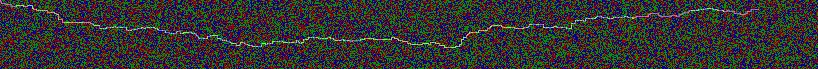

In [87]:
def process1(s, part2=False, visualize=False):
  lines = s.strip('\n').split('\n')
  depth = int(re.fullmatch(r'depth: (\d+)', lines[0]).group(1))
  pattern = r'target: (\d+),(\d+)'
  target_yx = tuple(map(int, re.fullmatch(pattern, lines[1]).groups()))[::-1]

  # region type:
  #  0: rocky '.'
  #  1: wet '='
  #  2: narrow '|'
  tools = {
      'neither': {1, 2},
      'torch': {0, 2},
      'climbing': {0, 1},
  }

  def construct_grid(shape):
    erosion_level = np.empty(shape, dtype=np.int64)
    for y, x in np.ndindex(shape):
      if y == 0:
        geologic_index = x * 16807
      elif x == 0:
        geologic_index = y * 48271
      elif (y, x) == target_yx:
        geologic_index = 0
      else:
        geologic_index = erosion_level[y - 1, x] * erosion_level[y, x - 1]
      erosion_level[y, x] = (geologic_index + depth) % 20183
    return erosion_level % 3

  if not part2:
    shape = tuple(np.array(target_yx) + 1)
    grid = construct_grid(shape)
    return grid.sum()

  pad = 60
  shape = tuple(np.array(target_yx) + pad)
  grid = construct_grid(shape)

  def get_neighbors(yx):
    y, x = yx
    if y: yield y - 1, x
    if y + 1 < shape[0]: yield y + 1, x
    if x: yield y, x - 1
    if x + 1 < shape[1]: yield y, x + 1

  # https://levelup.gitconnected.com/dijkstra-algorithm-in-python-8f0e75e3f16e
  distances = collections.defaultdict(lambda: 10**9)
  visited = set()
  parents = {}  # Optional, for visualize=True.
  source_tyx = 'torch', 0, 0
  target_tyx = 'torch', *target_yx
  distances[source_tyx] = 0
  pq = [(0, source_tyx)]

  while pq:
    distance, node = heapq.heappop(pq)
    if node in visited:
      continue
    visited.add(node)
    if node == target_tyx:
      break
    tool, yx = node[0], node[1:]
    neighbors = ([((tool, *yx2), 1) for yx2 in get_neighbors(yx)
                  if grid[yx2] in tools[tool]] +
                 [((tool2, *yx), 7) for tool2 in tools
                  if tool2 != tool and grid[yx] in tools[tool2]])
    for node2, edge_cost in neighbors:
      if node2 not in visited:
        distance2 = distance + edge_cost
        if distance2 < distances[node2]:
          distances[node2] = distance2
          heapq.heappush(pq, (distance2, node2))
          if visualize:
            parents[node2] = node
  else:
    assert False

  if visualize:
    cmap = {0: (150, 0 , 0), 1: (0, 150, 0), 2: (0, 0, 150)}
    image = np.array([cmap[e] for e in grid.ravel()], dtype=np.uint8)
    image = image.reshape(*grid.shape, 3)
    while node:
      image[node[1:]] += 105  # Let the path be brighter.
      node = parents.get(node, None)
    # x_max = (image.sum(2) > 0).max(axis=0).argmin() + 5
    image = image.transpose(1, 0, 2)
    media.show_image(image, height = image.shape[0] * 2)
    return None

  return distance


check_eq(process1(s1), 114)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s1), 45)
puzzle.verify(2, process2)
process2(puzzle.input, visualize=True)
# I also tried letting `tool` be in [0, 1, 2], `distances` and `visited` be
# 3D arrays, etc, but only got a 0.05 s improvement.

<a name="day23"></a>
## Day 23: Position in most octahedra

- Part 1: Find the nanobot with the largest signal radius. How many nanobots are in range of its signals?

- Part 2: Find the coordinates that are in range of the largest number of nanobots. What is the shortest manhattan distance between any of those points and `0,0,0`?

In [88]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2018/day/23), `puzzle.input` has 1000 lines:

pos=<17821750,69850551,48570194>, r=59707711
pos=<-9331508,90659413,35938523>, r=95038229
pos=<23833901,-25701718,28216348>, r=82407742
pos=<22578717,-4001237,33580852>, r=67327107
pos=<-15164551,39459126,39763570>, r=67792575
pos=<15583848,-13445920,16647903>, r=75695712
pos=<17429546,42820351,39605202>, r=55571372
pos=<25306171,10112187,37105526>, r=54010804
 ...
pos=<47372138,56694644,64140898>, r=73726557
pos=<-37628346,45604673,30927256>, r=75274807
pos=<9855134,42554936,63900237>, r=63813785
pos=<75613424,50145291,41345801>, r=72623408


The stored answers are: `{1: '599', 2: '94481130'}`

In [89]:
s1 = """
pos=<0,0,0>, r=4
pos=<1,0,0>, r=1
pos=<4,0,0>, r=3
pos=<0,2,0>, r=1
pos=<0,5,0>, r=3
pos=<0,0,3>, r=1
pos=<1,1,1>, r=1
pos=<1,1,2>, r=1
pos=<1,3,1>, r=1
"""

In [90]:
s2 = """
pos=<10,12,12>, r=2
pos=<12,14,12>, r=2
pos=<16,12,12>, r=4
pos=<14,14,14>, r=6
pos=<50,50,50>, r=200
pos=<10,10,10>, r=5
"""

In [91]:
def process1(s, part2=False, verbose=False):
  positions, radii = [], []
  for line in s.strip('\n').split('\n'):
    pattern = r'pos=<([0-9-]+),([0-9-]+),([0-9-]+)>, r=(\d+)'
    x, y, z, r = map(int, re.fullmatch(pattern, line).groups())
    positions.append((x, y, z))
    radii.append(r)
  positions, radii = np.array(positions), np.array(radii)

  show = hh.show if verbose else lambda *a, **k: None

  # With Manhattan distance, the in-range region in dimension D is a cocube
  # (e.g., an octahedron for D=3).  To efficiently represent intersections of
  # cocubes, we use a polytope (bounded convex polyhedron), defined as the
  # intersection of half-spaces (each hyperplane parallel to a cocube face).
  # The extent of the polytope is represented by an 2**D-dimensional vector `d`.
  # Each tuple coefficient d_i represents a hyperplane of a cocube face.
  # For D=3, each of the 8 half-spaces is a linear inequality on (x, y, z):
  #  h[0] * x + h[1] * y + h[2] * z <= d_i,
  # where face 0 has h = (-1, -1, -1),  face 1 has h = (-1, -1, 1), etc.

  hvalues = tuple(itertools.product((-1, 1), repeat=3))  # shape [8, 3]
  polytopes = [tuple(np.dot(h, position) + radius for h in hvalues)
               for position, radius in zip(positions, radii)]

  def num_in_range(position):
    return np.count_nonzero(abs(positions - position).sum(axis=1) <= radii)

  def point_in_polytope(position, polytope):
    return all(np.dot(h, position) <= d for h, d in zip(hvalues, polytope))

  def intersect(polytope1, polytope2):
    return tuple(np.minimum(polytope1, polytope2))

  def is_empty(polytope):
    # Note that half-space h[i] is in opposite direction of h[-(i + 1)].
    return (polytope[0] < -polytope[7] or polytope[1] < -polytope[6] or
            polytope[2] < -polytope[5] or polytope[3] < -polytope[4])

  def is_infinite(polytope):
    return min(polytope) == math.inf

  if not part2:
    if 1:  # Faster.
      i = radii.argmax()
      return np.count_nonzero(
          abs(positions - positions[i]).sum(axis=1) <= radii[i])
    else:  # Sanity check on polytopes.
      polytope = polytopes[radii.argmax()]
      return sum(1 for p in positions if point_in_polytope(p, polytope))

  # Estimate an initial position with a high count of overlapping octahedra.
  good_position = tuple(max(positions, key=num_in_range))

  distance_threshold, prune_allowance = 10_000_000, 8  # len(polytopes2) = 529, max_count = 528; 0.4 s

  while True:
    good_ds = tuple(np.dot(hvalue, good_position) for hvalue in hvalues)
    show(good_position, num_in_range(good_position))
    # good_position = (22000266, 38655032, 24842411), num_in_range(good_position) = 831

    # Modify a polytope to ignore any half-space whose linear boundary is
    # distant from good_position.
    def omit_far_halfspaces(polytope, good_ds):
      return tuple(d if abs(d - good_d) < distance_threshold else math.inf
                  for d, good_d in zip(polytope, good_ds))

    polytopes2 = [omit_far_halfspaces(p, good_ds) for p in polytopes]
    polytopes2 = [p for p in polytopes2 if not is_infinite(p)]
    show(len(polytopes2))

    # Heuristically order the polytopes.
    polytopes2 = sorted(polytopes2, key=lambda p: np.abs(p).min())
    polytopes2 = list(reversed(polytopes2))

    pieces = {}  # polytope -> count_of_original_octahedra
    for i, polytope in enumerate(polytopes2):
      new_pieces = {}
      for piece, count in pieces.items():
        piece2 = intersect(polytope, piece)
        if is_empty(piece2):
          continue
        new_pieces[piece2] = max(count + 1,
                                pieces.get(piece2, 0),
                                new_pieces.get(piece2, 0))
      pieces.update(new_pieces)
      pieces[polytope] = max(1, pieces.get(polytope, 0))
      if prune_allowance:
        pieces = {piece: count for piece, count in pieces.items()
                  if count > i - prune_allowance}
      show(i, len(pieces))

    max_count = max(pieces.values())
    max_list = [piece for piece, count in pieces.items() if count == max_count]
    best_polytope, = max_list
    show(len(pieces), len(polytopes2), max_count)
    if len(polytopes2) - max_count > prune_allowance:
      print('Warning: pruning too large to guarantee the optimal solution.')

    min_distance = math.inf
    # for c in set(itertools.product([-1, 0, 1], repeat=3)) - {0, 0, 0}:
    # for c in hvalues:
    for c in [-np.sign(good_position)]:
      c = np.array(c, dtype=np.float64)
      A_ub = np.array(hvalues)
      b_ub = np.nan_to_num(best_polytope, posinf=10**10)
      res = scipy.optimize.linprog(c, A_ub, b_ub, method='simplex')
      # show(res.x, res.fun, res.slack, res.status, res.nit, res.message)
      check_eq(res.success, True)
      # Handle the case of results with half-integer coordinates.
      upper = tuple(np.floor(np.mod(res.x, 1.0) + 1.499).astype(int))
      for delta in np.ndindex(upper):
        position = tuple((res.x + delta).astype(int))
        in_polytope = point_in_polytope(position, best_polytope)
        distance = np.abs(position).sum()
        # show(c, res.x, delta, position, in_polytope, distance, num_in_range(position))
        if in_polytope:
          min_distance = min(min_distance, distance)
          best_position = position
    distance_from_good = abs(np.array(best_position) - good_position).sum()
    hh.show(best_position, min_distance, distance_from_good, num_in_range(best_position))
    # best_position = (26794906, 46607439, 21078785), min_distance = 94481130, distance_from_good = 16510673, num_in_range(best_position) = 977
    if distance_from_good <= distance_threshold:
      break
    good_position = best_position
    prune_allowance = 4

  return min_distance


check_eq(process1(s1), 7)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s2), 36)
# puzzle.verify(2, process2)  # ~2.2 s.

(Part 1: 0.029 s)


best_position = (12, 12, 12), min_distance = 36, distance_from_good = 2, num_in_range(best_position) = 5


In [92]:
def process1(s, part2=False):
  # Divide-and-conquer using octree decomposition, inspired by
  # https://github.com/wimglenn/advent-of-code-wim/blob/master/aoc_wim/aoc2018/q23.py.
  pattern = r'pos=<([0-9-]+),([0-9-]+),([0-9-]+)>, r=(\d+)'
  data = np.array([list(map(int, re.fullmatch(pattern, line).groups()))
                   for line in s.strip('\n').split('\n')])
  xs, rs = data[:, :3], data[:, 3]
  i = rs.argmax()
  if not part2:
    return (abs(xs - xs[i]).sum(axis=1) <= rs[i]).sum()

  x0 = xs.min(axis=0)
  priority_queue = [(0, xs.ptp(axis=0).max(), abs(x0).sum(), *x0)]
  while priority_queue:
    n_out_of_range, s, d, *x = heapq.heappop(priority_queue)
    x = np.array(x)
    s //= 2
    if not s:
      # return d
      x0 = x
      break
    dx = np.array(list(itertools.product([0, 1], repeat=3))) * s
    for row in x + dx:  # Consider 8 octree child cells.
      # Maximize number in range = minimize number out of range.
      lo = np.maximum(row - xs, 0)
      hi = np.maximum(xs - row - s + 1, 0)  # (xs - row1);  row1 = row + s - 1
      n_out = ((lo + hi).sum(axis=1) > rs).sum()
      if n_out < len(rs):
        heapq.heappush(priority_queue, (n_out, s, abs(row).sum(), *row))
  else:
    assert False

  # Search around neighborhood of x0.
  r = 8
  for dx in itertools.product(range(-r, r + 1), repeat=3):
    x = x0 + dx
    n_out = (abs(xs - x).sum(axis=1) > rs).sum()
    n_out_of_range, d = min((n_out_of_range, d), (n_out, abs(x).sum()))

  return d

check_eq(process1(s1), 7)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s2), 36)
puzzle.verify(2, process2)

(Part 1: 0.004 s)
(Part 2: 0.294 s)


In [93]:
def process1(s, part2=False):
  # Divide-and-conquer using octree decomposition, adapted from
  # https://github.com/wimglenn/advent-of-code-wim/blob/master/aoc_wim/aoc2018/q23.py.
  # Improved to be robust (not assuming cubes with power-of-two dimensions).
  pattern = r'pos=<([0-9-]+),([0-9-]+),([0-9-]+)>, r=(\d+)'
  data = np.array([list(map(int, re.fullmatch(pattern, line).groups()))
                   for line in s.strip('\n').split('\n')])
  xs, rs = data[:, :-1], data[:, -1]
  if not part2:
    i = rs.argmax()
    return (abs(xs - xs[i]).sum(axis=1) <= rs[i]).sum()

  xl, xh = xs.min(axis=0), xs.max(axis=0)
  pq = [(0, (xh - xl).max(), abs(xl).sum(), tuple(xl), tuple(xh))]
  while pq:
    n_out, s, d, xl, xh = heapq.heappop(pq)
    if s == 0:
      return d
    xm = (np.array(xl) + xh) // 2  # Partition into up to 8 octree child cells.
    for child_min_max in itertools.product(
        *(((l, m), (m + 1, h)) if m < h else ((l, h),)
          for l, m, h in zip(xl, xm, xh))):
      xl, xh = np.array(child_min_max).T
      n_out = ((np.maximum(xl - xs, 0) + np.maximum(xs - xh, 0)).sum(axis=1)
               > rs).sum()  # Maximize num in-range = minimize num out-of-range.
      heapq.heappush(
          pq, (n_out, (xh - xl).max(), abs(xl).sum(), tuple(xl), tuple(xh)))


check_eq(process1(s1), 7)
puzzle.verify(1, process1)

process2 = functools.partial(process1, part2=True)
check_eq(process2(s2), 36)
puzzle.verify(2, process2)

(Part 1: 0.004 s)
(Part 2: 0.075 s)


<a name="day24"></a>
## Day 24: Armies with groups of units

- Part 1: How many units would the winning army have?

- Part 2: How many units does the immune system have left after getting the smallest boost it needs to win?

In [94]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2018/day/24), `puzzle.input` has 23 lines:

Immune System:
956 units each with 7120 hit points (weak to bludgeoning, slashing) with an atta ... 71 radiation damage at initiative 7
1155 units each with 5643 hit points (weak to bludgeoning; immune to cold) with  ... 42 slashing damage at initiative 15
1658 units each with 5507 hit points (weak to cold; immune to bludgeoning, slash ... 32 radiation damage at initiative 3
5009 units each with 8078 hit points with an attack that does 14 slashing damage at initiative 8
22 units each with 4771 hit points (weak to radiation) with an attack that does 1906 bludgeoning damage at initiative 18
115 units each with 9090 hit points (immune to slashing; weak to bludgeoning) wi ... 72 slashing damage at initiative 17
1062 units each with 11023 hit points (immune to cold, radiation; weak to bludge ... oes 93 fire damage at initiative 19
 ...
3143 units each with 53472 hit points (immune to cold; weak to fire) with an att ... 30 slashing damage at initiative 16
451 units each with 28782 hit points

The stored answers are: `{1: '15392', 2: '1092'}`

In [95]:
s1 = """
Immune System:
17 units each with 5390 hit points (weak to radiation, bludgeoning) with an attack that does 4507 fire damage at initiative 2
989 units each with 1274 hit points (immune to fire; weak to bludgeoning, slashing) with an attack that does 25 slashing damage at initiative 3

Infection:
801 units each with 4706 hit points (weak to radiation) with an attack that does 116 bludgeoning damage at initiative 1
4485 units each with 2961 hit points (immune to radiation; weak to fire, cold) with an attack that does 12 slashing damage at initiative 4
"""

In [96]:
def simulate_immune_fight(s, verbose=False, boost=0, immune_must_win=False):

  @dataclasses.dataclass
  class Group:
    army: 'Army'
    id: int
    units: int
    hit_points: int  # (per_unit)
    attack_damage: int  # (per unit)
    attack_type: str
    initiative: int  # Higher initiative attacks first and wins ties.
    attributes: Dict[str, Set]  # ['immune'] and ['weak']
    target: 'Group'
    targeted: bool

    def __init__(self, army, id, line):
      self.army = army
      self.id = id
      pattern = (r'(\d+) units each with (\d+) hit points( \(.*\))? with'
                 r' an attack that does (\d+) (.*) damage at initiative (\d+)')
      (units, hit_points, attributes, attack_damage, attack_type,
       initiative) = re.fullmatch(pattern, line).groups()
      (self.units, self.hit_points, self.attack_damage, self.attack_type,
       self.initiative) = (int(units), int(hit_points), int(attack_damage),
                           attack_type, int(initiative))
      self.attributes = {'immune': set(), 'weak': set()}
      if attributes:
        for attribute in attributes[2:-1].split('; '):
          t, ss = attribute.split(' to ')
          for s in ss.split(', '):
            self.attributes[t].add(s)
      if boost and army.name == 'Immune System':
        self.attack_damage += boost

    def effective_power(self):
      return self.units * self.attack_damage

    def selection_order(self):
      return (-self.effective_power(), -self.initiative)

  @dataclasses.dataclass
  class Army:
    name: str
    groups: List[Group]

    def __init__(self, s):
      lines = s.split('\n')
      self.name = lines[0][:-1]
      self.groups = [Group(self, i + 1, line)
                     for i, line in enumerate(lines[1:])]

  armies = [Army(s_army) for s_army in s.strip('\n').split('\n\n')]

  def get_opponent(army):
    return next(army2 for army2 in armies if army2 != army)

  def compute_damage(group, target):
    assert group.army != target.army
    damage = group.effective_power()
    if group.attack_type in target.attributes['immune']:
      damage = 0
    if group.attack_type in target.attributes['weak']:
      damage *= 2
    return damage

  while True:
    if verbose:
      for army in armies:
        print(f'{army.name}:')
        for group in army.groups:
          print(f'Group {group.id} contains {group.units} units')
      print()

    if any(not army.groups for army in armies):
      break

    # Target selection.
    for army in armies:
      for group in army.groups:
        group.targeted = False
    for army in armies:
      opponent = get_opponent(army)
      for group in sorted(army.groups, key=lambda g: g.selection_order()):
        target = max(opponent.groups, key=lambda g: (
            not g.targeted, compute_damage(group, g),
            g.effective_power(), g.initiative))
        damage = compute_damage(group, target)
        if target.targeted or damage == 0:
          group.target = None
        else:
          group.target = target
          target.targeted = True
          if verbose and target:
            print(f'{army.name} group {group.id} would deal defending'
                  f' group {target.id} {damage} damage')
    if verbose:
      print()

    # Attacking.
    total_killed = 0
    for group in sorted((group for army in armies for group in army.groups),
                        key=lambda g: -g.initiative):
      if group.units == 0 or not group.target or group.target.units == 0:
        continue
      target = group.target
      damage = compute_damage(group, target)
      units_killed = min(damage // target.hit_points, target.units)
      if verbose:
        print(f'{group.army.name} group {group.id} attacks defending'
              f' group {target.id}, killing {units_killed} units')
      target.units -= units_killed
      total_killed += units_killed
    if verbose:
      print()
    if total_killed == 0:
      return None  # The fight is a draw.

    # Remove empty groups.
    for army in armies:
      army.groups = [group for group in army.groups if group.units > 0]

  army = next(army for army in armies if army.groups)
  if immune_must_win and army.name != 'Immune System':
    return None
  return sum(group.units for group in army.groups)


process1 = simulate_immune_fight

check_eq(process1(s1), 5216)
puzzle.verify(1, process1)

(Part 1: 0.099 s)


In [97]:
def process2(s):

  def boost_result(boost):
    return simulate_immune_fight(s, boost=boost, immune_must_win=True)

  def binary_search(func, lower, upper):
    """Returns lowest x for which bool(func(x)) is True."""
    if 0:
      check_eq(func(lower), None)
      check_eq(func(upper) is not None, True)
    while lower + 1 < upper:
      mid = (lower + upper) // 2
      value = func(mid)
      if value:
        upper = mid
      else:
        lower = mid
    return upper

  boost = binary_search(boost_result, lower=0, upper=2_000)
  print(f'Found solution with boost={boost}')
  return boost_result(boost)


check_eq(simulate_immune_fight(s1, boost=1570), 51)
check_eq(process2(s1), 51)

puzzle.verify(2, process2)

Found solution with boost=1570
Found solution with boost=46
(Part 2: 1.269 s)


<a name="day25"></a>
## Day 25: Clustering nearby 4D points

- Part 1: Given a set of 4D points, what is the number of clusters of points when edges connect points with Manhattan distance 3 or less?

- Part 2: No second part on day 25.

In [98]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2018/day/25), `puzzle.input` has 1441 lines:

4,-5,0,-4
0,3,-3,2
-6,5,-7,4
6,-3,-1,-3
-5,4,0,-6
8,-6,-7,7
0,-7,6,5
-5,-6,4,0
 ...
2,1,-7,-7
-7,-8,5,1
2,-1,-3,1
0,-6,-3,-3


The stored answers are: `{1: '359', 2: ''}`

In [99]:
s1 = """
 0,0,0,0
 3,0,0,0
 0,3,0,0
 0,0,3,0
 0,0,0,3
 0,0,0,6
 9,0,0,0
12,0,0,0
"""

s2 = """
-1,2,2,0
0,0,2,-2
0,0,0,-2
-1,2,0,0
-2,-2,-2,2
3,0,2,-1
-1,3,2,2
-1,0,-1,0
0,2,1,-2
3,0,0,0
"""

s3 = """
1,-1,0,1
2,0,-1,0
3,2,-1,0
0,0,3,1
0,0,-1,-1
2,3,-2,0
-2,2,0,0
2,-2,0,-1
1,-1,0,-1
3,2,0,2
"""

s4 = """
1,-1,-1,-2
-2,-2,0,1
0,2,1,3
-2,3,-2,1
0,2,3,-2
-1,-1,1,-2
0,-2,-1,0
-2,2,3,-1
1,2,2,0
-1,-2,0,-2
"""

In [100]:
class UnionFind:
  """Union-find is an efficient technique for tracking equivalence classes as
  pairs of elements are incrementally unified into the same class.
  The implementation uses path compression but without weight-balancing, so the
  worst case time complexity is O(nlogn), but the average case is O(n).
  """

  def __init__(self):
    self._rep = {}

  def unify(self, a: Any, b: Any) -> None:
    """Merge the equivalence classes of elements a and b."""
    rep_a, rep_b = self.get_rep(a), self.get_rep(b)
    self._rep[rep_b] = rep_a

  def same(self, a: Any, b: Any) -> bool:
    """Returns whether a and b are in the same equivalence class."""
    return self._rep.get(a, a) == self._rep.get(b, b)

  def get_rep(self, a: Any) -> Any:
    """Returns a representative for the class of a; valid until next unify()."""
    if a not in self._rep:
      return a
    parents = []
    while True:
      parent = self._rep.setdefault(a, a)
      if parent == a:
        break
      parents.append(a)
      a = parent
    for p in parents:
      self._rep[p] = a
    return a


def test_union_find():
  union_find = UnionFind()
  check_eq(union_find.same(12, 12), True)
  check_eq(union_find.same(12, 23), False)
  check_eq(union_find.same(12, 35), False)
  check_eq(union_find.same(23, 35), False)
  union_find.unify(12, 23)
  check_eq(union_find.same(12, 12), True)
  check_eq(union_find.same(12, 23), True)
  check_eq(union_find.same(12, 35), False)
  check_eq(union_find.same(23, 35), False)
  union_find.unify(23, 35)
  check_eq(union_find.same(12, 12), True)
  check_eq(union_find.same(12, 23), True)
  check_eq(union_find.same(12, 35), True)
  check_eq(union_find.same(23, 35), True)

test_union_find()

In [101]:
def process1(s):  # Slower version.
  points = [tuple(map(int, l.split(','))) for l in s.strip('\n').split('\n')]

  union_find = UnionFind()
  num_edges = 0
  for i in range(len(points)):
    for j in range(i + 1, len(points)):
      p, q = points[i], points[j]
      if (abs(p[0] - q[0]) + abs(p[1] - q[1]) +
          abs(p[2] - q[2]) + abs(p[3] - q[3])) <= 3:
        num_edges += 1
        union_find.unify(i, j)

  print(f'Graph has {len(points)} vertices and {num_edges} edges.')
  cluster_reps = {union_find.get_rep(i) for i in range(len(points))}
  return len(cluster_reps)


def process1(s):  # Faster version, using numpy to identify the graph edges.
  points = [[int(t) for t in l.split(',')] for l in s.strip('\n').split('\n')]
  points = np.array(points)
  union_find = UnionFind()
  edges = abs(points[None] - points.reshape(-1, 1, 4)).sum(axis=-1) <= 3
  for i, j in np.argwhere(edges):
    union_find.unify(i, j)
  return len({union_find.get_rep(i) for i in range(len(points))})


check_eq(process1(s1), 2)
check_eq(process1(s2), 4)
check_eq(process1(s3), 3)
check_eq(process1(s4), 8)

puzzle.verify(1, process1)

(Part 1: 0.115 s)


In [102]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)
# (aocd does not allow a blank answer; the answer is not submitted)

(Part 2: 0.000 s)


<a name="timings"></a>
## Timings

In [103]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.050
day_2    part_1: 0.003   part_2: 0.006
day_3    part_1: 0.336   part_2: 0.331
day_4    part_1: 0.003   part_2: 0.004
day_5    part_1: 0.010   part_2: 0.252
day_6    part_1: 0.132   part_2: 0.077
day_7    part_1: 0.000   part_2: 0.004
day_8    part_1: 0.010   part_2: 0.010
day_9    part_1: 0.025   part_2: 2.119
day_10   part_1: 0.270   part_2: 0.267
day_11   part_1: 0.003   part_2: 0.071
day_12   part_1: 0.003   part_2: 0.051
day_13   part_1: 0.041   part_2: 0.658
day_14   part_1: 0.333   part_2: 1.419
day_15   part_1: 0.916   part_2: 1.894
day_16   part_1: 0.020   part_2: 0.024
day_17   part_1: 0.126   part_2: 0.113
day_18   part_1: 0.015   part_2: 0.710
day_19   part_1: 0.000   part_2: 0.001
day_20   part_1: 1.012   part_2: 0.892
day_21   part_1: 0.001   part_2: 0.634
day_22   part_1: 0.019   part_2: 1.136
day_23   part_1: 0.004   part_2: 0.075
day_24   part_1: 0.099   part_2: 1.269
day_25   part_1: 0.115   part_2: 0.000
Total time: 15.567 s


In [104]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [105]:
if 0:  # Look for unwanted pollution of namespace.
  print(textwrap.fill(' '.join(var for var, value in globals().items() if (
      not var.startswith('_') and not repr(value).startswith(
          ('<module', '<class', 'typing.', 'functools.partial('))))))

In [106]:
if 0:  # Save puzzle inputs and answers to a ZIP file for downloading.
  # Create a new zip file, quietly (-q) and ignoring relative paths (-j).
  !zip -q -j - ~/.config/aocd/'{PROFILE.replace("_", " ")}'/*.txt >/content/data.zip

# End